# Anticipez les besoins en consommations de bâtiments

## Objectif

L'objectif de ce projet est de prédire les émissions de CO2 et la consommation totale d'énergie de bâtiments non destinés à l'habitation de la ville de Seattle à partir de leurs données structurelles (taille, usage, date de construction, localisation) afin d'atteindre l'objectif de neutralité carbone de la ville en 2050.

## 1. Installation du projet et de son environnement

Afin d’utiliser correctement ce notebook, vérifiez que vous disposez du bon environnement pour l’exécuter.


### 1.1 Installation de Python

Pour ce projet, il est nécessaire d’avoir **au minimum Python 3.8**.  
Si ce n’est pas déjà le cas, vous pouvez vous référer à [la documentation officielle](https://www.python.org/downloads/).

Vérifiez votre version de Python :

```bash
python --version
```

### 1.2 Installation de `uv`

`uv` est un gestionnaire de projets Python permettant d’installer et d’organiser les dépendances plus rapidement et plus simplement que les outils traditionnels (`pip`, `virtualenv`, etc.).

Pour installer `uv`, veuillez suivre [la documentation officielle](https://docs.astral.sh/uv/getting-started/installation/#standalone-installer)

Vérifiez l’installation :

```bash
uv --version
```

### 1.3 Création du projet

Créez un nouveau projet Python avec `uv` :

```bash
uv init nom_du_projet
cd nom_du_projet
```

La structure de base du projet est alors générée automatiquement.


### 1.4 Création et activation de l’environnement virtuel

Créez l’environnement virtuel :

```bash
uv venv
```

Activez-le selon votre système :

* **Linux / macOS**

```bash
source .venv/bin/activate
```

* **Windows (PowerShell)**

```powershell
.venv\Scripts\Activate.ps1
```

Voir la documentation officielle :
[https://docs.astral.sh/uv/pip/environments/#creating-a-virtual-environment](https://docs.astral.sh/uv/pip/environments/#creating-a-virtual-environment)



### 1.5 Installation des dépendances

> ❗ Assurez-vous que l’environnement virtuel est **activé** avant d’installer les dépendances.

Installez les bibliothèques nécessaires au projet :

```bash
uv add ipykernel jupyterlab seaborn matplotlib numpy pandas scikit-learn tqdm scipy
```

Ces dépendances sont automatiquement enregistrées dans le fichier `pyproject.toml`.

Vous pouvez visualiser l’ensemble des dépendances installées avec la commande suivante :

```bash
uv tree


## 2. Importation des Bibliothèques


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.axes import Axes
import seaborn as sns
import numpy as np
from scipy import stats
from typing import List, Union

In [2]:
def distribution_column(df: pd.DataFrame, column: str):
    """
    Affiche la distribution de la colonne 'Outlier' dans le DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant la colonne 'Outlier'.
    """
    print(f"📊 Distribution de la colonne {column}")
    print("-" * 100)
    
    outlier_counts = df[column].value_counts(dropna=False)
    outlier_pct = df[column].value_counts(dropna=False, normalize=True) * 100
    
    outlier_summary = pd.DataFrame({
        'Effectif': outlier_counts,
        'Pourcentage': outlier_pct.round(2)
    })
    
    display(outlier_summary)

def display_columns_info(df: pd.DataFrame, columns: List[str]):
    for col in columns:
        n_unique = df[col].nunique()
        n_missing = df[col].isna().sum()
        pct_unique = (n_unique / len(df)) * 100
        pct_missing = (n_missing / len(df)) * 100
        
        print(f"• {col}:")
        print(f"  - Type : {df[col].dtype}")
        print(f"  - Valeurs uniques: {n_unique} ({pct_unique:.1f}%)")
        print(f"  - Valeurs manquantes: {n_missing} ({pct_missing:.1f}%)")
        
        # Afficher les valeurs si peu nombreuses
        if n_unique <= 10:
            print(f"  - Valeurs: {df[col].unique()}")
        print("")

def remove_columns(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Supprime les colonnes spécifiées du DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame d'origine.
        columns (list): Liste des noms de colonnes à supprimer.

    Returns:
        pd.DataFrame: Le DataFrame sans les colonnes supprimées.
    """
    print("📦 Suppression de colonnes")
    print(f"   ➤ Shape initiale        : {df.shape}")
    print(f"   ➤ Colonnes demandées    : {len(columns)}")

    # Colonnes réellement présentes
    existing_cols = [col for col in columns if col in df.columns]
    missing_cols = [col for col in columns if col not in df.columns]

    df = df.drop(columns=existing_cols)

    print(f"✅ Suppression terminée")
    print(f"   ➤ Shape finale          : {df.shape}")
    print(f"   ➤ Colonnes supprimées   : {len(existing_cols)}")

    if existing_cols:
        print(f"   🧹 Liste supprimée       : {existing_cols}")

    if missing_cols:
        print(f"   ⚠️ Colonnes inexistantes : {missing_cols}")

    return df

def compare_describe_statistics(
    df_ref,
    df_comp,
    columns,
    stats=('mean', '50%', 'std'),
    stat_labels=('Moyenne', 'Médiane', 'Écart-type'),
    ref_label='Avec outliers',
    comp_label='Sans outliers',
    n_cols=2,
    figsize=(16, 12),
    title="Comparaison des statistiques descriptives",
    summary_columns=None,
    mean_alert_thresholds=(5, 10)
):
    """
    Compare les statistiques issues de df.describe() entre deux dataframes.

    Parameters
    ----------
    df_ref : pd.DataFrame
        DataFrame de référence (ex : avec outliers)

    df_comp : pd.DataFrame
        DataFrame comparé (ex : sans outliers)

    columns : list
        Colonnes numériques à comparer

    stats : tuple
        Statistiques issues de describe() à comparer

    stat_labels : tuple
        Labels affichés pour les statistiques

    ref_label / comp_label : str
        Libellés affichés dans les graphiques

    n_cols : int
        Nombre de colonnes dans la grille matplotlib

    figsize : tuple
        Taille de la figure

    title : str
        Titre global

    summary_columns : list or None
        Colonnes incluses dans le résumé textuel

    mean_alert_thresholds : tuple
        Seuils (%) pour interpréter l'impact sur la moyenne
    """

    desc_ref = df_ref[columns].describe()
    desc_comp = df_comp[columns].describe()

    n_rows = int(np.ceil(len(columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.995)

    for idx, col in enumerate(columns):
        ax = axes[idx]

        ref_values = [desc_ref.loc[s, col] for s in stats]
        comp_values = [desc_comp.loc[s, col] for s in stats]

        variations = [
            ((comp - ref) / ref * 100) if ref != 0 else np.nan
            for ref, comp in zip(ref_values, comp_values)
        ]

        x = np.arange(len(stats))
        width = 0.35

        ax.bar(
            x - width / 2,
            ref_values,
            width,
            label=ref_label,
            color='#e74c3c',
            alpha=0.8
        )

        bars_comp = ax.bar(
            x + width / 2,
            comp_values,
            width,
            label=comp_label,
            color='#2ecc71',
            alpha=0.8
        )

        ax.set_title(col, fontweight='bold')
        ax.set_ylabel('Valeur')
        ax.set_xticks(x)
        ax.set_xticklabels(stat_labels)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        # Annotation variation %
        for bar, delta in zip(bars_comp, variations):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{delta:+.1f}%",
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold',
                color='green' if delta < 0 else 'red'
            )

    # Supprimer axes inutilisés
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    # ======================
    # Résumé textuel
    # ======================
    if summary_columns is None:
        summary_columns = columns

    print("\n" + "=" * 80)
    print("RÉSUMÉ DE LA COMPARAISON DES STATISTIQUES")
    print("=" * 80)

    mod_threshold, high_threshold = mean_alert_thresholds

    for col in summary_columns:
        ref_mean = desc_ref.loc['mean', col]
        comp_mean = desc_comp.loc['mean', col]
        delta_mean = ((comp_mean - ref_mean) / ref_mean * 100) if ref_mean != 0 else np.nan

        print(f"\n{col} :")
        for s, label in zip(stats, stat_labels):
            ref_val = desc_ref.loc[s, col]
            comp_val = desc_comp.loc[s, col]
            delta = ((comp_val - ref_val) / ref_val * 100) if ref_val != 0 else np.nan

            print(f"   • {label} : {delta:+.2f}%")

        if abs(delta_mean) > high_threshold:
            print(f"   ⚠️ Impact FORT sur la moyenne (>{high_threshold}%)")
        elif abs(delta_mean) > mod_threshold:
            print(f"   ⚡ Impact MODÉRÉ sur la moyenne")
        else:
            print(f"   ✅ Impact FAIBLE sur la moyenne")

## 3. Chargement du jeu de donnée

- **Jeu de données** : [2016_Building_Energy_Benchmarking.csv](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv)
- **Source officielle** : [Building Energy Benchmarking - Seattle Open Data](https://data.seattle.gov/Built-Environment/Building-Energy-Benchmarking-Data-2015-Present/teqw-tu6e/about_data)

> 📁 **Action** : Téléchargez le jeu de données et ajoutez-le dans le dossier `data/`

In [3]:
# Configuration de l'affichage pandas
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
pd.set_option('display.width', None)         # Largeur automatique

df_origin = pd.read_csv('data/2016_Building_Energy_Benchmarking.csv')

df = df_origin.copy()

## 4. Choix des variables cibles

Pour répondre à l'objectif, je dois choisir 2 variables cibles. L'une pour prédire les émissions de CO2 et l'autre pour la consommation totale d'énergie.

### Sélection des variables cibles

Après analyse du dataset, je choisis les 2 variables cibles suivantes :

**1. Pour les émissions de CO2 :** `TotalGHGEmissions`
- Émissions totales de gaz à effet de serre (en tonnes métriques de CO2)

**2. Pour la consommation d'énergie :** `SiteEnergyUse(kBtu)`
- Consommation totale d'énergie du site (en kBtu)

#### Alternatives non retenues

**Pour les émissions de CO2 :**
- `GHGEmissionsIntensity` : Mesure d'intensité (émissions par surface en sq ft), moins pertinente pour l'objectif global de neutralité carbone de la ville qui nécessite les émissions totales absolues

**Pour la consommation d'énergie :**
- `SiteEnergyUseWN(kBtu)` : Version normalisée par la météo, moins représentative de la consommation réelle
- `SourceEUI(kBtu/sf)` : Mesure d'intensité énergétique (par surface), pas la consommation totale
- `SiteEUI(kBtu/sf)` : Intensité d'usage du site par surface, ne reflète pas la consommation totale
- `Electricity(kWh)`, `NaturalGas(therms)`, `SteamUse(kBtu)` : Mesures partielles par type d'énergie, ne représentent pas la consommation totale agrégée

In [4]:
TARGET_CO2 = 'TotalGHGEmissions'
TARGET_ENERGY = 'SiteEnergyUse(kBtu)'

## 5. Information générale du Dataset

In [5]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [6]:
display(df.shape)

(3376, 46)

**Dimensions du dataset :**
- 3376 lignes (bâtiments)
- 46 colonnes

In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

None

#### Synthèse de la structure des données

**Types de données :**
- 8 colonnes numériques entières (`int64`)
- 22 colonnes numériques décimales (`float64`)
- 15 colonnes textuelles (`object`)
- 1 colonne booléenne (`bool`)

**Colonnes à analyser pouvant contenir des lignes problématiques :**
- `Outlier` : indique si un bâtiment est considéré comme un outlier
- `ComplianceStatus` : indique si un bâtiment a satisfait aux exigences réglementaires de déclaration énergétique

**Valeurs manquantes importantes :**
- `Comments` : 0 valeur renseignée (colonne complètement vide)
- `YearsENERGYSTARCertified` : 119 / 3376 (3,5 %)
- `Outlier` : 32 / 3376 (0,9 %)
- `ThirdLargestPropertyUseType(GFA)` : 596 / 3376 (17,7 %)
- `SecondLargestPropertyUseType(GFA)` : 1679 / 3376 (49,7 %)
- `ENERGYSTARScore` : 2533 / 3376 (75,0 %)

**Variables cibles : couverture excellente**
- `TotalGHGEmissions` : 3367 / 3376 (99,7 %)
- `SiteEnergyUse(kBtu)` : 3371 / 3376 (99,9 %)

**Points d'attention :**
- `ZipCode` : stocké en `float64` au lieu de `string` (16 valeurs manquantes)



In [8]:
df.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


### Synthèse des statistiques descriptives

**Colonnes analysées :** 22 colonnes numériques (sur 46 au total)

**Observations principales :**

1. **Caractéristiques des bâtiments :**
   - Année de construction : entre 1900 et 2015 (médiane : 1975)
   - Nombre d'étages : 0 à 99 (médiane : 4 étages)
   - Surface totale (PropertyGFATotal) : très variable de 11,285 à 9,320,156 sq ft

2. **Valeurs aberrantes détectées :**
   - `Electricity(kWh)` : valeur minimale négative (-33,827)
   - `Electricity(kBtu)` : valeur minimale négative (-115,417)
   - `TotalGHGEmissions` : valeur minimale négative (-0.8)
   - `GHGEmissionsIntensity` : valeur minimale négative (-0.02)
   - `SourceEUIWN(kBtu/sf)` : valeur minimale négative (-2.1)

3. **Distribution des variables cibles :**
   - **TotalGHGEmissions :** moyenne = 119.7, médiane = 33.9 (distribution asymétrique)
   - **SiteEnergyUse(kBtu) :** moyenne = 5.4M, médiane = 1.8M (forte variabilité)

4. **Forte variabilité :**
   - Les écarts-types sont très élevés pour la plupart des variables énergétiques
   - Présence probable de valeurs extrêmes (outliers)
   - Exemple : SteamUse varie de 0 à 134M kBtu

5. **Score ENERGYSTAR :**
   - Moyenne : 67.9/100 (sur 2533 bâtiments notés)
   - 75% des bâtiments notés ont un score ≥ 53

In [9]:
def analyze_missing_values(df: pd.DataFrame, display_table: bool = True) -> pd.DataFrame:
    """
    Analyse les valeurs manquantes dans un DataFrame.
    
    Args:
        df (pd.DataFrame): Le DataFrame à analyser.
        display_table (bool): Si True, affiche le tableau détaillé des valeurs manquantes.
    
    Returns:
        pd.DataFrame: DataFrame avec les statistiques de valeurs manquantes par colonne.
    """
    # 1. Pourcentage global de cellules vides
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isna().sum().sum()
    pct_missing_global = (missing_cells / total_cells) * 100
    
    print(f"\n🌐 Pourcentage de cellules vides sur tout le DataFrame : {pct_missing_global:.2f}%")
    
    # 2. Pourcentage par colonne
    missing_by_column = df.isna().sum()
    pct_by_column = (missing_by_column / len(df)) * 100
    
    # Créer un DataFrame pour les statistiques
    missing_df = pd.DataFrame({
        'Colonne': df.columns,
        'Valeurs manquantes': missing_by_column.values,
        'Pourcentage (%)': pct_by_column.values
    })
    
    # Trier par pourcentage décroissant
    missing_df = missing_df.sort_values('Pourcentage (%)', ascending=False)
    
    # Afficher le tableau si demandé
    # if display_table:
    #     print(f"\n📋 Pourcentage de cellules vides par colonne :")
    #     print("-" * 80)
    #     display(missing_df[missing_df['Pourcentage (%)'] > 0])

    return missing_df

def display_missing_values(df: pd.DataFrame):
    """
    Analyse les valeurs manquantes dans un DataFrame.
    
    Args:
        df (pd.DataFrame): Le DataFrame à analyser.
        display_table (bool): Si True, affiche le tableau détaillé des valeurs manquantes.
    
    Returns:
        pd.DataFrame: DataFrame avec les statistiques de valeurs manquantes par colonne.
    """
    print(f"\n📋 Pourcentage de cellules vides par colonne :")
    print("-" * 80)
    missing_stats = analyze_missing_values(df, True)
    display(missing_stats[missing_stats['Pourcentage (%)'] > 0])


def plot_missing_values(missing_df: pd.DataFrame, top_n: int = 15, min_threshold: float = 0.1):
    """
    Visualise les valeurs manquantes sous forme de graphique à barres horizontales.
    
    Args:
        missing_df (pd.DataFrame): DataFrame retourné par analyze_missing_values().
        top_n (int): Nombre maximum de colonnes à afficher (par défaut: 15).
        min_threshold (float): Pourcentage minimum pour afficher une colonne (par défaut: 0.1%).
    """
    # Filtrer les colonnes selon le seuil
    missing_cols = missing_df[missing_df['Pourcentage (%)'] >= min_threshold].head(top_n).copy()
    
    if len(missing_cols) > 0:
        fig, ax = plt.subplots(figsize=(14, max(6, len(missing_cols) * 0.4)))
        
        # Créer le graphique horizontal
        bars = ax.barh(range(len(missing_cols)), missing_cols['Pourcentage (%)'])
        ax.set_yticks(range(len(missing_cols)))
        ax.set_yticklabels(missing_cols['Colonne'], fontsize=10)
        ax.set_xlabel('Pourcentage de valeurs manquantes (%)', fontsize=12, fontweight='bold')
        ax.set_title('Principales colonnes avec valeurs manquantes', fontsize=14, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Colorer les barres selon le niveau de gravité
        colors = ['#2ecc71' if x < 1 else '#f39c12' if x < 5 else '#e74c3c' 
                  for x in missing_cols['Pourcentage (%)']]
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        # Ajouter les valeurs sur les barres
        for i, (idx, row) in enumerate(missing_cols.iterrows()):
            ax.text(row['Pourcentage (%)'] + 0.5, i, f"{row['Pourcentage (%)']:.2f}%", 
                    va='center', fontsize=9, fontweight='bold')
        
        legend_elements = [
            Patch(facecolor='#2ecc71', label='< 1% manquant (excellente couverture)'),
            Patch(facecolor='#f39c12', label='1-5% manquant (bonne couverture)'),
            Patch(facecolor='#e74c3c', label='> 5% manquant (attention requise)')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
        
        # Ajuster les marges pour éviter les warnings
        plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.1)
        plt.show()
    else:
        print(f"✅ Aucune colonne avec ≥ {min_threshold}% de valeurs manquantes !")



🌐 Pourcentage de cellules vides sur tout le DataFrame : 12.85%


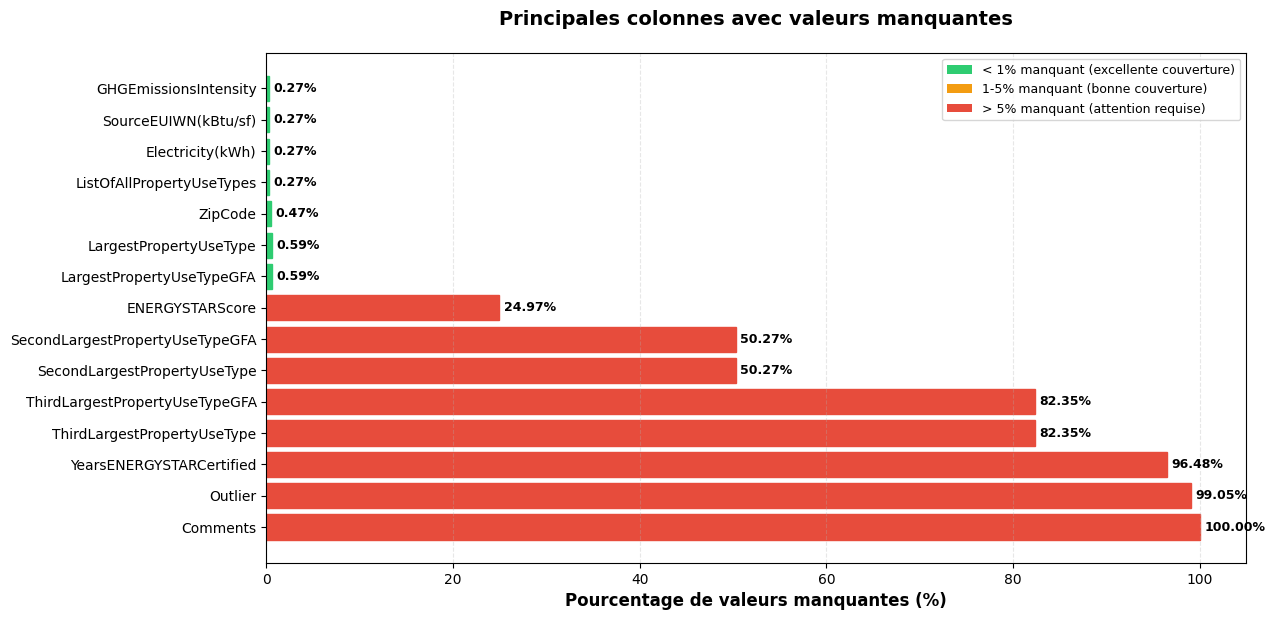

In [10]:
missing_stats = analyze_missing_values(df, True)
plot_missing_values(missing_stats, top_n=15, min_threshold=0.1)

## 6. Filtrage des bâtiments non résidentiels

Pour le projet, nous avons uniquement besoin des bâtiments non résidentiels. Pour cela, nous allons commencer par filtrer le jeu de données.

In [11]:
df["BuildingType"].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

**Observations :**

- **NonResidential (1 460)** : Bâtiments non résidentiels  
- **Multifamily LR (1–4) (1 018)** : Immeubles multifamiliaux à faible densité  
- **Multifamily MR (5–9) (580)** : Immeubles multifamiliaux à densité moyenne  
- **Multifamily HR (10+) (110)** : Immeubles multifamiliaux à haute densité  
- **SPS-District K–12 (98)** : Établissements scolaires publics (de la maternelle au lycée)  
- **Nonresidential COS (85)** : Bâtiments municipaux de la ville de Seattle  
- **Campus (24)** : Ensembles de bâtiments interconnectés  
- **Nonresidential WA (1)** : Bâtiment appartenant à l’État de Washington  

Dans le cadre du projet, seuls les bâtiments **non destinés à l’habitation** sont requis. Par conséquent, nous conserverons uniquement les catégories suivantes :

- **NonResidential (1 460)** : Bâtiments non résidentiels  
- **SPS-District K–12 (98)** : Établissements scolaires publics  
- **Nonresidential COS (85)** : Bâtiments municipaux de Seattle  
- **Campus (24)** : Ensembles de bâtiments interconnectés
- **Nonresidential WA (1)**: Bâtiment de l’État de Washington


In [12]:
print(f"Nombre de lignes avant filtrage par type de batiment : {len(df)}")

# Types de bâtiments à conserver
building_types_to_keep = [
    "NonResidential",
    "SPS-District K-12",
    "Nonresidential COS",
    "Campus",
    "Nonresidential WA"
]

# Filtrer les données
df = df[df['BuildingType'].isin(building_types_to_keep)]

# Documenter le nombre de lignes après filtrage
print(f"Nombre de lignes après filtrage : {len(df)}")
print(f"Nombre de lignes supprimées : {len(df_origin) - len(df)}")
# Afficher la répartition des types de bâtiments conservés
print("\nRépartition des types de bâtiments conservés :")
print(df['BuildingType'].value_counts())

Nombre de lignes avant filtrage par type de batiment : 3376
Nombre de lignes après filtrage : 1668
Nombre de lignes supprimées : 1708

Répartition des types de bâtiments conservés :
BuildingType
NonResidential        1460
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: count, dtype: int64


## 7. Vérification des doublons

La vérification des doublons est essentielle pour garantir la qualité des données avant toute analyse ou modélisation. Des doublons peuvent fausser les statistiques, introduire des biais dans les modèles prédictifs et conduire à des conclusions erronées.

### Stratégie de détection

Je vais vérifier les doublons selon plusieurs niveaux de granularité :

1. **Doublons complets** : Lignes identiques sur toutes les colonnes (très rare)
2. **Doublons sur l'identifiant** : `OSEBuildingID` (doit être unique par définition)
3. **Doublons géographiques** : Combinaison `Address + City + ZipCode`

### Pourquoi plusieurs vérifications ?

- Un même bâtiment pourrait avoir des données légèrement différentes (erreurs de saisie, mises à jour)
- Plusieurs bâtiments pourraient partager une même adresse (complexes immobiliers)

In [13]:
def verify_duplicates(
    df: pd.DataFrame,
    columns: Union[List[str], None] = None,
    display_table: bool = False,
    preview_rows: int = 10
) -> int:
    """
    Vérifie les doublons dans un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame à analyser
        columns (list[str] | None): Colonnes à utiliser pour la détection.
        display_table (bool): Si True, affiche les lignes dupliquées
        preview_rows (int): Nombre de lignes dupliquées à afficher

    Returns:
        int: Nombre de doublons détectés
    """
    if df.empty:
        print("⚠️ Le DataFrame est vide.")
        return 0

    subset = None
    if columns:
        missing_cols = set(columns) - set(df.columns)
        if missing_cols:
            raise ValueError(f"Colonnes inexistantes : {missing_cols}")
        subset = columns
        label = f"Doublons sur {columns}"
    else:
        label = "Toutes les colonnes"

    duplicates = df.duplicated(subset=subset).sum()
    percentage = (duplicates / len(df)) * 100

    print(f"\n Colonnes concernés : {label} ")
    print(f"\n🔍 Nombre de doublons : {duplicates}")
    print(f"📊 Pourcentage : {percentage:.2f}%")

    if duplicates > 0 and display_table:
        print("\n🔍 Aperçu des lignes dupliquées :")
        print("-" * 80)

        sort_cols = subset if subset else df.columns.tolist()
        duplicated_rows = (
            df[df.duplicated(subset=subset, keep=False)]
            .sort_values(by=sort_cols)
        )

        try:
            display(duplicated_rows.head(preview_rows))
        except NameError:
            print(duplicated_rows.head(preview_rows))

    return duplicates

# Exécution des vérifications
print(f"📊 ANALYSE DES DOUBLONS")
print(f"="*80)

# 1. Vérifier le nombre total de lignes dupliquées (toutes colonnes confondues)
print("\nVérification des doublons complets (toutes colonnes)")
total_duplicates = verify_duplicates(df)

# 2. Vérifier les doublons sur l'identifiant unique du bâtiment
print("\nVérification sur l'identifiant OSEBuildingID")
id_duplicates = verify_duplicates(df, ['OSEBuildingID'])

# 3. Vérifier les doublons sur l'adresse
print("\nVérification sur l'adresse")
address_duplicates = verify_duplicates(df, ['Address', 'City', 'ZipCode'])

📊 ANALYSE DES DOUBLONS

Vérification des doublons complets (toutes colonnes)

 Colonnes concernés : Toutes les colonnes 

🔍 Nombre de doublons : 0
📊 Pourcentage : 0.00%

Vérification sur l'identifiant OSEBuildingID

 Colonnes concernés : Doublons sur ['OSEBuildingID'] 

🔍 Nombre de doublons : 0
📊 Pourcentage : 0.00%

Vérification sur l'adresse

 Colonnes concernés : Doublons sur ['Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 20
📊 Pourcentage : 1.20%


In [14]:
print("\nVérification sur l'adresse + nom de la propriété")
address_duplicates = verify_duplicates(df, ['PropertyName', 'Address', 'City', 'ZipCode'])


Vérification sur l'adresse + nom de la propriété

 Colonnes concernés : Doublons sur ['PropertyName', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 0
📊 Pourcentage : 0.00%


In [15]:
print("\n Vérification avec le rajout de la longitude et latitude")
address_duplicates = verify_duplicates(df, ['Latitude', 'Longitude', 'Address', 'City', 'ZipCode'])


 Vérification avec le rajout de la longitude et latitude

 Colonnes concernés : Doublons sur ['Latitude', 'Longitude', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 19
📊 Pourcentage : 1.14%


In [16]:
print("\nVérification avec le rajout du type de bâtiment")
address_duplicates = verify_duplicates(df, ['BuildingType', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'])


Vérification avec le rajout du type de bâtiment

 Colonnes concernés : Doublons sur ['BuildingType', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 19
📊 Pourcentage : 1.14%


In [17]:
print("\nVérification avec le rajout de l'année de construction")
address_duplicates = verify_duplicates(df, ['BuildingType', 'YearBuilt', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'], True)


Vérification avec le rajout de l'année de construction

 Colonnes concernés : Doublons sur ['BuildingType', 'YearBuilt', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 7
📊 Pourcentage : 0.42%

🔍 Aperçu des lignes dupliquées :
--------------------------------------------------------------------------------


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
2148,24600,2016,NonResidential,Medical Office,Navos Psychiatric Hospital,2600 SW Holden St,Seattle,WA,98126.0,7985400265,1,DELRIDGE,47.53419,-122.36624,1970,1.0,1,43615,0,43615,Medical Office,Medical Office,43615.0,NaN,NaN,NaN,NaN,NaN,89.0,71.900002,77.699997,137.899994,144.000000,3133849.500,3.389213e+06,0.0,3.817273e+05,1302454.0,18313.960940,1831396.0,False,NaN,Compliant,NaN,106.35,2.44
2149,24601,2016,NonResidential,Small- and Mid-Sized Office,Navos Erlick Perez,2600 SW Holden St,Seattle,WA,98126.0,7985400265,1,DELRIDGE,47.53419,-122.36624,1970,1.0,3,36879,0,36879,Office,Office,16855.0,NaN,NaN,NaN,NaN,NaN,26.0,67.900002,71.000000,213.199997,222.899994,1144267.500,1.196289e+06,0.0,3.353656e+05,1144267.0,0.000000,0.0,False,NaN,Compliant,NaN,7.98,0.22
597,799,2016,NonResidential,Distribution Center,Cloverdale Business Park Building D,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,54880,0,54880,Distribution Center,Distribution Center,55000.0,NaN,NaN,NaN,NaN,NaN,32.0,50.200001,54.799999,99.900002,104.699997,2763597.000,3.013862e+06,0.0,3.636542e+05,1240788.0,15228.089840,1522809.0,False,NaN,Compliant,NaN,89.53,1.63
2123,24537,2016,NonResidential,Warehouse,Cloverdale Business Park Building B,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,33320,0,33320,"Non-Refrigerated Warehouse, Office",Non-Refrigerated Warehouse,32200.0,Office,1200.0,NaN,NaN,NaN,NaN,70.000000,74.800003,154.199997,159.300003,2339234.000,2.499645e+06,0.0,3.778526e+05,1289233.0,10500.010740,1050001.0,False,NaN,Compliant,NaN,64.75,1.94
2124,24538,2016,NonResidential,Warehouse,Cloverdale Business Park Building C,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,48020,0,48020,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,47800.0,NaN,NaN,NaN,NaN,NaN,71.0,49.700001,53.700001,115.599998,119.800003,2373568.250,2.567828e+06,0.0,4.251196e+05,1450508.0,9230.599609,923060.0,False,NaN,Compliant,NaN,59.14,1.23
2125,24539,2016,NonResidential,Warehouse,Cloverdale Business Park Building E,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,27420,0,27420,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,27850.0,NaN,NaN,NaN,NaN,NaN,55.0,42.200001,48.099998,82.500000,88.599998,1176342.250,1.340563e+06,0.0,1.488110e+05,507743.0,6685.990234,668599.0,False,NaN,Compliant,NaN,39.05,1.42
2235,24895,2016,NonResidential,Supermarket / Grocery Store,Promenade South 1,2309 S Jackson St,Seattle,WA,98144.0,3646100390,3,CENTRAL,47.59881,-122.30189,1980,1.0,1,30630,0,30630,"Other, Supermarket/Grocery Store",Supermarket/Grocery Store,28470.0,Other,2442.0,NaN,NaN,NaN,27.0,196.000000,200.399994,615.400024,629.200012,6058494.000,6.194518e+06,0.0,1.775643e+06,6058493.0,0.000000,0.0,False,NaN,Compliant,NaN,42.24,1.38
2236,24896,2016,NonResidential,Retail Store,Promenade South 2,2309 S Jackson St,Seattle,WA,98144.0,3646100390,3,CENTRAL,47.59881,-122.30189,1980,1.0,2,23421,0,23421,"Bank Branch, Retail Store",Retail Store,19271.0,Bank Branch,4150.0,NaN,NaN,NaN,25.0,81.00

In [18]:
print("\nVérification avec le rajout du type d'utilisation principale")
address_duplicates = verify_duplicates(df, ['BuildingType', 'LargestPropertyUseType', 'YearBuilt', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'], True)


Vérification avec le rajout du type d'utilisation principale

 Colonnes concernés : Doublons sur ['BuildingType', 'LargestPropertyUseType', 'YearBuilt', 'Latitude', 'Longitude', 'Address', 'City', 'ZipCode'] 

🔍 Nombre de doublons : 3
📊 Pourcentage : 0.18%

🔍 Aperçu des lignes dupliquées :
--------------------------------------------------------------------------------


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
2123,24537,2016,NonResidential,Warehouse,Cloverdale Business Park Building B,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,33320,0,33320,"Non-Refrigerated Warehouse, Office",Non-Refrigerated Warehouse,32200.0,Office,1200.0,NaN,NaN,NaN,NaN,70.000000,74.800003,154.199997,159.300003,2339234.00,2.499645e+06,0.0,3.778526e+05,1289233.0,10500.010740,1050001.0,False,NaN,Compliant,NaN,64.75,1.94
2124,24538,2016,NonResidential,Warehouse,Cloverdale Business Park Building C,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,48020,0,48020,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,47800.0,NaN,NaN,NaN,NaN,NaN,71.0,49.700001,53.700001,115.599998,119.800003,2373568.25,2.567828e+06,0.0,4.251196e+05,1450508.0,9230.599609,923060.0,False,NaN,Compliant,NaN,59.14,1.23
2125,24539,2016,NonResidential,Warehouse,Cloverdale Business Park Building E,309 South Cloverdale Street,Seattle,WA,98108.0,3224049012,1,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,27420,0,27420,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,27850.0,NaN,NaN,NaN,NaN,NaN,55.0,42.200001,48.099998,82.500000,88.599998,1176342.25,1.340563e+06,0.0,1.488110e+05,507743.0,6685.990234,668599.0,False,NaN,Compliant,NaN,39.05,1.42
530,717,2016,Nonresidential COS,Warehouse,Airport Way Ctr - Bldg C,2203 Airport Way S,Seattle,WA,98134.0,7666203240,2,GREATER DUWAMISH,47.58290,-122.32417,1985,1.0,2,145158,0,145158,"Non-Refrigerated Warehouse, Office, Other",Non-Refrigerated Warehouse,101633.0,Office,48544.0,Other,10270.0,NaN,51.0,52.299999,53.700001,146.899994,148.000000,8384523.00,8.615958e+06,0.0,2.069794e+06,7062138.0,13223.847660,1322385.0,False,NaN,Compliant,NaN,119.46,0.82
1969,23975,2016,Nonresidential COS,Warehouse,Airport Way Ctr - Bldg D,2203 Airport Way S,Seattle,WA,98134.0,7666203240,2,GREATER DUWAMISH,47.58290,-122.32417,1985,1.0,1,22803,0,22803,"Non-Refrigerated Warehouse, Other",Non-Refrigerated Warehouse,19373.0,Other,3430.0,NaN,NaN,NaN,78.0,33.500000,37.700001,73.099998,77.000000,764094.50,8.593872e+05,0.0,1.212340e+05,413650.0,3504.440186,350444.0,False,NaN,Compliant,NaN,21.50,0.94


In [19]:
# 4. Vérification finale : doublons sur les variables cibles
print("\nVérification sur les variables cibles (consommations énergétiques identiques)")
print("-" * 80)
print("\nCette vérification détecte les bâtiments ayant exactement les mêmes valeurs")
print("de consommation énergétique ET d'émissions de CO2.")
print("Un tel cas serait hautement suspect et pourrait indiquer un vrai doublon.\n")

# Vérifier sur les deux variables cibles simultanément
target_duplicates = verify_duplicates(
    df,
    [TARGET_ENERGY, TARGET_CO2],
    display_table=True,
    preview_rows=10
)


Vérification sur les variables cibles (consommations énergétiques identiques)
--------------------------------------------------------------------------------

Cette vérification détecte les bâtiments ayant exactement les mêmes valeurs
de consommation énergétique ET d'émissions de CO2.
Un tel cas serait hautement suspect et pourrait indiquer un vrai doublon.


 Colonnes concernés : Doublons sur ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'] 

🔍 Nombre de doublons : 5
📊 Pourcentage : 0.30%

🔍 Aperçu des lignes dupliquées :
--------------------------------------------------------------------------------


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
28,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,3,Central,47.62266,-122.30547,1955,1.0,1,126351,0,126351,K-12 School,K-12 School,126351.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,NaN,Missing Data,NaN,0.0,0.0
152,242,2016,SPS-District K-12,K-12 School,Olympic View Elementary,504 N.E. 95th St.,Seattle,WA,98115.0,5100404840,5,NORTH,47.69823,-122.32126,1989,1.0,2,52792,0,52792,K-12 School,K-12 School,55480.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,NaN,Missing Data,NaN,0.0,0.0
304,435,2016,NonResidential,Other,Washington State Convention Center,705 Pike St,Seattle,WA,98101.0,1978200105,7,DOWNTOWN,47.61195,-122.33167,1990,1.0,6,1400000,0,1400000,"Convention Center, Parking",Convention Center,1072000.0,Parking,686750.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,NaN,Non-Compliant,NaN,0.0,0.0
746,19776,2016,NonResidential,Other,Welcome Home Society - PriceCo,13537 Aurora Ave N,Seattle,WA,98133.0,0164000020,5,NORTHWEST,47.72777,-122.34503,2002,1.0,1,29924,0,29924,Other - Education,Other - Education,29924.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,NaN,Missing Data,NaN,0.0,0.0
1361,21616,2016,SPS-District K-12,K-12 School,Olympic Hills Elementary,13018 20th Ave. N.E.,Seattle,WA,98125.0,2126049041,5,NORTH,47.72369,-122.30676,1954,1.0,1,42292,0,42292,K-12 School,K-12 School,43188.0,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN,Error - Correct Default Data,NaN,0.0,0.0
578,773,2016,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,Seattle,WA,98104.0,0939000245,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN
2670,26532,2016,NonResidential,Mixed Use Property,KALBERG BUILDING,4515 UNIVERSITY WAY NE,Seattle,WA,98105.0,8816401120,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN,NaN


### Conclusion sur l'analyse des doublons

Après avoir effectué une analyse exhaustive des doublons selon différents critères, voici les résultats :

#### Résultats des vérifications

| Critère de vérification | Doublons détectés | Statut |
|------------------------|-------------------|--------|
| **Lignes totalement identiques** | 0 | ✅ OK |
| **Identifiant unique (`OSEBuildingID`)** | 0 | ✅ OK |
| **Adresse géographique** (`Address + City + ZipCode`) | 20 | ⚠️ À analyser |
| **Adresse + Nom du bâtiment** | 0 | ✅ OK |
| **Coordonnées GPS + Adresse** | 19 | ⚠️ À analyser |
| **+ Type de bâtiment + Année** | 7 | ⚠️ À analyser |
| **+ Type d'utilisation principale** | 3 | ⚠️ À analyser |
| **Variables cibles identiques** | 5 | ⚠️ Valeurs manquantes |

#### Interprétation

**Aucun vrai doublon détecté** ✅

##### 1. Doublons géographiques (21 cas)

Les 20 "doublons" détectés sur l'adresse géographique correspondent à des **bâtiments distincts partageant la même adresse**, ce qui est légitime dans le cas de :

- **Complexes immobiliers** : Plusieurs bâtiments au sein d'un même parc d'affaires
  - Exemple : *Cloverdale Business Park* (bâtiments B, C, E)
  - Exemple : *Airport Way Center* (bâtiments C, D)

**Preuves de distinction** :
- Chaque ligne a un **`OSEBuildingID` unique** (identifiant officiel)
- Chaque bâtiment a un **`PropertyName` différent**
- Les **surfaces** (`PropertyGFATotal`) sont différentes
- Les **consommations énergétiques** sont différentes
- Les **émissions de CO2** sont différentes

##### 2. Doublons sur variables cibles (10 cas)

Les 5 "doublons" détectés sur les variables cibles (`SiteEnergyUse(kBtu)` et `TotalGHGEmissions`) correspondent en réalité à des **bâtiments sans données énergétiques**.

**Explication** : Ces bâtiments partagent les mêmes valeurs de variables cibles car elles sont toutes **manquantes (NaN)**. La fonction `duplicated()` de pandas considère que deux valeurs NaN sont identiques.

**Nature du problème** : Il ne s'agit pas de doublons mais de **valeurs manquantes** qui devront être traitées lors de l'étape de nettoyage des données.

#### Décision

**Aucune suppression de lignes n'est nécessaire.** 

- Toutes les observations représentent des bâtiments uniques et légitimes
- Les bâtiments sans données énergétiques seront traités lors de la gestion des valeurs manquantes

Le dataset est prêt pour l'analyse exploratoire et la modélisation sans risque de biais lié aux doublons.

## 8. Vérification des colonnes pouvant contenir des lignes problématiques


### 8.1 La colonne `Outlier`

In [20]:
distribution_column(df, 'Outlier')

📊 Distribution de la colonne Outlier
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
Outlier,,
NaN,1651,98.98
Low outlier,15,0.90
High outlier,2,0.12


**Observation :**

La variable *Outlier* comporte trois états :
- **Low outlier** : valeur anormalement basse détectée ;
- **High outlier** : valeur anormalement élevée ;
- **Valeur manquante** : aucune anomalie identifiée.

On constate que les bâtiments identifiés comme *outliers* ne représentent que **0,92 %** du jeu de données.

In [21]:
# Afficher uniquement les Low Outliers
colonnes_a_afficher = ['BuildingType', 'PrimaryPropertyType', 'DefaultData', 'ComplianceStatus', 'ENERGYSTARScore', 'Outlier', TARGET_CO2, TARGET_ENERGY]

low_outliers_stats = df[df['Outlier'] == 'Low outlier']
print("Statistiques pour Low Outliers:")
display(low_outliers_stats[colonnes_a_afficher].head(15))



Statistiques pour Low Outliers:


,BuildingType,PrimaryPropertyType,DefaultData,ComplianceStatus,ENERGYSTARScore,Outlier,TotalGHGEmissions,SiteEnergyUse(kBtu)
384,NonResidential,Retail Store,False,Non-Compliant,100.0,Low outlier,2.22,3.189628e+05
448,NonResidential,Large Office,False,Non-Compliant,100.0,Low outlier,29.43,1.119592e+07
839,SPS-District K-12,K-12 School,True,Error - Correct Default Data,100.0,Low outlier,11.54,4.314717e+05
1045,NonResidential,Retail Store,True,Error - Correct Default Data,100.0,Low outlier,5.46,1.454688e+05
1229,NonResidential,Small- and Mid-Sized Office,False,Non-Compliant,NaN,Low outlier,0.17,2.410550e+04
1295,NonResidential,Other,False,Non-Compliant,NaN,Low outlier,0.31,4.429350e+04
1611,NonResidential,Worship Facility,False,Non-Compliant,100.0,Low outlier,0.70,1.008417e+05
1945,NonResidential,Small- and Mid-Sized Office,False,Non-Compliant,100.0,Low outlier,8.59,2.848573e+05
2129,NonResidential,K-12 School,False,Non-Compliant,100.0,Low outlier,1.12,1.613634e+05
2189,NonResidential,Other,False,Non-Compliant,NaN,Low outlier,0.12,1.680890e+04


**Observations des Low Outliers (15 bâtiments - 0.90%)** :
- **ENERGYSTARScore** : valeurs très élevées (99, 100) ou manquantes (NaN)
- **ComplianceStatus** : principalement "Non-Compliant" ou "Error - Correct Default Data"
- **Interprétation** : ces bâtiments ont une consommation d'énergie anormalement **faible** malgré leur non-conformité, ce qui suggère des données potentiellement erronées ou incomplètes

In [22]:
# Afficher uniquement les High Outliers
high_outliers_stats = df[df['Outlier'] == 'High outlier']
print("Statistiques pour High Outliers:")
display(high_outliers_stats[colonnes_a_afficher].head())

Statistiques pour High Outliers:


,BuildingType,PrimaryPropertyType,DefaultData,ComplianceStatus,ENERGYSTARScore,Outlier,TotalGHGEmissions,SiteEnergyUse(kBtu)
226,NonResidential,Large Office,False,Non-Compliant,NaN,High outlier,362.66,41399504.0
517,NonResidential,Large Office,False,Non-Compliant,1.0,High outlier,189.18,27137190.0


**Observations sur les High Outliers (2 bâtiments - 0.12%)** :
- **ENERGYSTARScore** : valeurs très faibles (1) ou manquantes (NaN)
- **ComplianceStatus** : "Non-Compliant"
- **Interprétation** : ces bâtiments ont une consommation d'énergie anormalement **élevée** et sont également non-conformes, ce qui est cohérent avec leur mauvaise performance énergétique

**Synthèse** : Les outliers (17 bâtiments au total, soit 1.02% du dataset) présentent systématiquement des problèmes de conformité et des scores ENERGY STAR extrêmes ou absents, renforçant l'hypothèse de problèmes de qualité des données.

#### Identification de la Méthode de Détection

In [23]:
# Tester différentes métriques avec la méthode IQR
for metric in [TARGET_ENERGY, TARGET_CO2, 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'GHGEmissionsIntensity']:
    # 1. Calcul IQR
    Q1 = df[metric].quantile(0.25)
    Q3 = df[metric].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # 2. Calcul Z-score
    z_scores = stats.zscore(df[metric].dropna())
    abs_z_scores = np.abs(z_scores)

    # Identification des outliers
    outliers_z2 = df[metric].dropna()[abs_z_scores > 2]
    outliers_iqr = df[(df[metric] < lower) | (df[metric] > upper)]

    # Calculer le rappel (recall) pour les outliers détectés
    high_detected = df[(df[metric] > upper) & (df['Outlier'] == 'High outlier')]
    low_detected = df[(df[metric] < lower) & (df['Outlier'] == 'Low outlier')]
    print(f"\nMétrique: {metric}")
    print(f"Nombre de high outliers détectés via IQR: {len(outliers_iqr[outliers_iqr['Outlier'] == 'High outlier'])}")
    print(f"Nombre de low outliers détectés via IQR: {len(outliers_iqr[outliers_iqr['Outlier'] == 'Low outlier'])}")

    print(f"Nombre de high outliers détectés via z-score (seuil = 2): {len(outliers_z2[df['Outlier'] == 'High outlier'])}")
    print(f"Nombre de low outliers détectés via z-score(seuil = 2): {len(outliers_z2[df['Outlier'] == 'Low outlier'])}")


Métrique: SiteEnergyUse(kBtu)
Nombre de high outliers détectés via IQR: 2
Nombre de low outliers détectés via IQR: 0
Nombre de high outliers détectés via z-score (seuil = 2): 0
Nombre de low outliers détectés via z-score(seuil = 2): 0

Métrique: TotalGHGEmissions
Nombre de high outliers détectés via IQR: 1
Nombre de low outliers détectés via IQR: 0
Nombre de high outliers détectés via z-score (seuil = 2): 0
Nombre de low outliers détectés via z-score(seuil = 2): 0

Métrique: ENERGYSTARScore
Nombre de high outliers détectés via IQR: 0
Nombre de low outliers détectés via IQR: 0
Nombre de high outliers détectés via z-score (seuil = 2): 1
Nombre de low outliers détectés via z-score(seuil = 2): 0

Métrique: SiteEUI(kBtu/sf)
Nombre de high outliers détectés via IQR: 2
Nombre de low outliers détectés via IQR: 0
Nombre de high outliers détectés via z-score (seuil = 2): 2
Nombre de low outliers détectés via z-score(seuil = 2): 0

Métrique: SourceEUI(kBtu/sf)
Nombre de high outliers détectés vi

**Observation :**

Les tests de détection d'outliers révèlent que **ni la méthode IQR ni le Z-score ne permettent d'identifier les outliers marqués dans la colonne**.

Résultats :
- **Méthode IQR** : détecte seulement 1-2 bâtiments parmi les 17 outliers marqués sur les métriques cibles
- **Z-score (seuil = 2 )** :  détecte seulement 1 outliers sur la métrique ENERGYSTARScore

**Conclusion :** La colonne `Outlier` ne provient probablement **pas d'une méthode statistique classique**, mais plutôt :
- D'une **règle métier spécifique** liée aux exigences réglementaires
- D'une **validation manuelle** par les autorités de Seattle
- D'une **détection d'anomalies contextuelles** (ex: données incohérentes avec le type de bâtiment)

Cette hypothèse est renforcée par le fait que **100% des outliers sont non-conformes ou en erreur**.

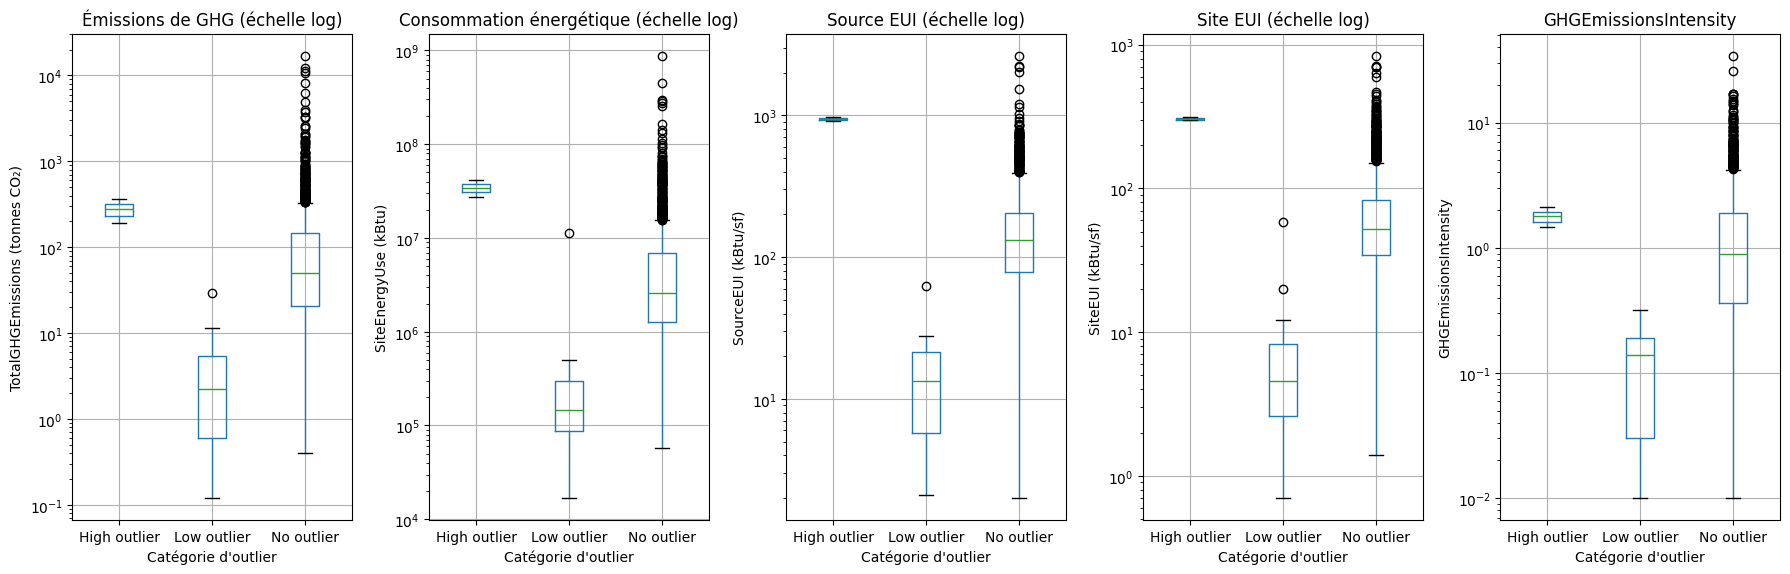

In [24]:

from typing import List, Optional, Tuple

def create_boxplot_by_category(df: pd.DataFrame,
                               column: str,
                               category_column: str,
                               ax: plt.Axes,
                               title: str,
                               ylabel: str,
                               xlabel: str = "Catégorie d'outlier",
                               log_scale: bool = True,
                               exclude_non_positive: bool = True) -> None:
    """
    Crée un boxplot d'une variable par catégorie avec options de mise en forme.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame source
    column : str
        Nom de la colonne à visualiser
    category_column : str
        Nom de la colonne de catégories
    ax : plt.Axes
        Axes matplotlib sur lequel dessiner
    title : str
        Titre du graphique
    ylabel : str
        Label de l'axe Y
    xlabel : str
        Label de l'axe X
    log_scale : bool
        Utiliser une échelle logarithmique
    exclude_non_positive : bool
        Exclure les valeurs <= 0
    """
    # Filtrer les données si nécessaire
    if exclude_non_positive:
        df_plot = df[df[column] > 0].copy()
    else:
        df_plot = df.copy()
    
    # Créer le boxplot
    df_plot.boxplot(column=column, by=category_column, ax=ax)
    
    # Appliquer l'échelle log si demandé
    if log_scale:
        ax.set_yscale('log')
    
    # Mise en forme
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.get_figure().suptitle('')  # Supprimer le titre automatique


def visualize_variables_by_outlier_category(df: pd.DataFrame,
                                            variables: List[dict],
                                            category_column: str = 'Outlier_Category',
                                            figsize: Tuple[int, int] = (16, 6),
                                            main_title: str = "Distribution des variables par catégorie d'outlier") -> None:
    """
    Crée une visualisation multi-graphiques des variables par catégorie d'outlier.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame source
    variables : List[dict]
        Liste de dictionnaires contenant les paramètres pour chaque variable:
        - 'column': nom de la colonne
        - 'title': titre du graphique
        - 'ylabel': label de l'axe Y
        - 'xlabel': (optionnel) label de l'axe X
        - 'log_scale': (optionnel) utiliser échelle log
        - 'exclude_non_positive': (optionnel) exclure valeurs <= 0
    category_column : str
        Nom de la colonne de catégories
    figsize : Tuple[int, int]
        Taille de la figure
    main_title : str
        Titre principal de la figure
        
    Example:
    --------
    variables = [
        {
            'column': 'TotalGHGEmissions',
            'title': 'Émissions de GHG (échelle log)',
            'ylabel': 'TotalGHGEmissions (tonnes CO₂)',
            'log_scale': True
        },
        {
            'column': 'SiteEnergyUse',
            'title': 'Consommation énergétique (échelle log)',
            'ylabel': 'SiteEnergyUse (kBtu)',
            'log_scale': True
        }
    ]
    visualize_variables_by_outlier_category(df, variables)
    """
    n_vars = len(variables)
    fig, axes = plt.subplots(1, n_vars, figsize=figsize)
    fig.suptitle(main_title, fontsize=14, fontweight='bold')
    
    # S'assurer que axes est toujours une liste
    if n_vars == 1:
        axes = [axes]
    
    for i, var_params in enumerate(variables):
        # Paramètres par défaut
        params = {
            'xlabel': "Catégorie d'outlier",
            'log_scale': True,
            'exclude_non_positive': True
        }
        # Mettre à jour avec les paramètres fournis
        params.update(var_params)
        
        create_boxplot_by_category(
            df=df,
            column=params['column'],
            category_column=category_column,
            ax=axes[i],
            title=params['title'],
            ylabel=params['ylabel'],
            xlabel=params['xlabel'],
            log_scale=params['log_scale'],
            exclude_non_positive=params['exclude_non_positive']
        )
    
    plt.tight_layout()
    plt.show()

df_outlier = df.copy()
df_outlier['Outlier_Category'] = df_outlier['Outlier'].fillna('No outlier')

variables = [
    {
        'column': TARGET_CO2,
        'title': 'Émissions de GHG (échelle log)',
        'ylabel': 'TotalGHGEmissions (tonnes CO₂)'
    },
    {
        'column': TARGET_ENERGY,
        'title': 'Consommation énergétique (échelle log)',
        'ylabel': 'SiteEnergyUse (kBtu)'
    },
    {
        'column': 'SourceEUI(kBtu/sf)',
        'title': 'Source EUI (échelle log)',
        'ylabel': 'SourceEUI (kBtu/sf)'
    },
    {
        'column': 'SiteEUI(kBtu/sf)',
        'title': 'Site EUI (échelle log)',
        'ylabel': 'SiteEUI (kBtu/sf)'
    },
    {
        'column': 'GHGEmissionsIntensity',
        'title': 'GHGEmissionsIntensity',
        'ylabel': 'GHGEmissionsIntensity'
    }
]

visualize_variables_by_outlier_category(
    df=df_outlier,
    variables=variables,
    figsize=(18, 6)
)

**Observations** :
- Les catégories "No outlier" présentent systématiquement les dispersions les plus importantes sur tous les indicateurs
- Les "High outlier" ont des valeurs élevées mais concentrées
- Les "Low outlier" montrent généralement des valeurs faibles avec peu de dispersion
- L'échelle logarithmique révèle des différences de 3 à 4 ordres de grandeur entre les bâtiments
- Une forte corrélation semble exister entre les différents indicateurs énergétiques

#### Conclusion et décision de traitement des outliers

Les bâtiments identifiés comme *outliers* représentent une part très faible du jeu de données (17 bâtiments, soit environ **1 %**). Cependant, ils présentent tous des **problèmes de qualité des données**.

Ces bâtiments sont majoritairement **non conformes** ou associés à des **erreurs de déclaration**, avec des **scores ENERGY STAR extrêmes ou manquants**. Les méthodes statistiques classiques (IQR, Z-score) ne permettent pas de les détecter, ce qui indique que la variable `Outlier` repose sur des **règles métier ou réglementaires**, et non sur une logique statistique exploitable en modélisation.

De plus, leurs distributions sont peu dispersées et atypiques par rapport au reste du dataset, ce qui pourrait **biaiser les modèles prédictifs**.

#### Décision retenue
- **Suppression de la colonne `Outlier`**
- **Exclusion des 17 bâtiments outliers du dataset de modélisation**

Cette décision est justifiée par :
- des **données non fiables**
- un **risque de biais élevé**
- un **impact négligeable sur la taille et la représentativité** du jeu de données
- la volonté de **privilégier la qualité des données** pour la modélisation


In [25]:
# Supprimer les lignes marquées comme outliers (High outlier ou Low outlier)
# Garder uniquement les lignes où Outlier est NaN (pas d'outlier)
df_clean = df[df['Outlier'].isna()].copy()

# Afficher le résultat
print(f"📊 Résultat du nettoyage:")
print(f"   • Taille initiale      : {len(df):,} lignes")
print(f"   • Taille après nettoyage : {len(df_clean):,} lignes")
print(f"   • Lignes supprimées    : {len(df) - len(df_clean)} lignes ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")

df = df_clean

📊 Résultat du nettoyage:
   • Taille initiale      : 1,668 lignes
   • Taille après nettoyage : 1,651 lignes
   • Lignes supprimées    : 17 lignes (1.02%)


In [26]:
df = remove_columns(df, ['Outlier'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1651, 46)
   ➤ Colonnes demandées    : 1
✅ Suppression terminée
   ➤ Shape finale          : (1651, 45)
   ➤ Colonnes supprimées   : 1
   🧹 Liste supprimée       : ['Outlier']


### 8.2. La colonne `ComplianceStatus`

• ComplianceStatus:
  - Type : object
  - Valeurs uniques: 4 (0.2%)
  - Valeurs manquantes: 0 (0.0%)
  - Valeurs: ['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Compliant']



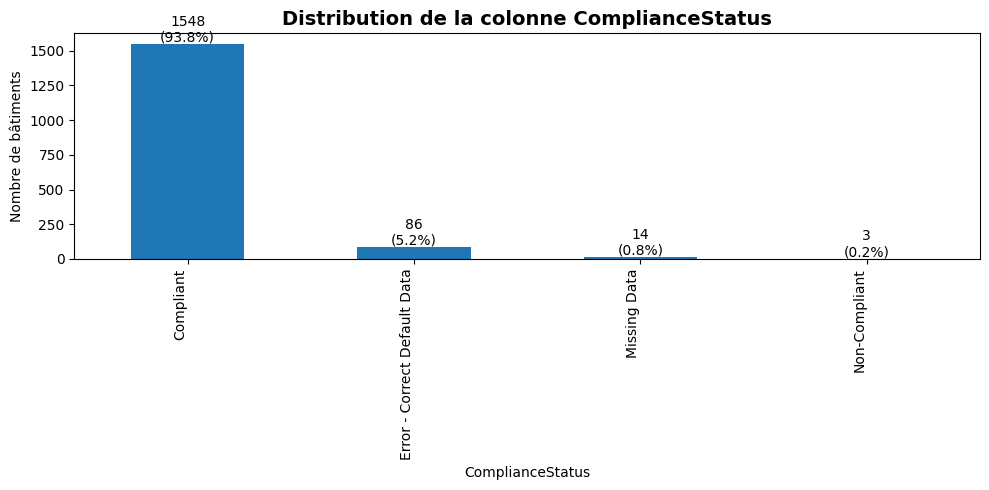

In [27]:
def analyze_missing(df: pd.DataFrame, column: str, target: str):
    total = len(df[target]);
    n_value = df[column].value_counts()

    # Valeurs manquantes
    missing = df[target].isna().groupby(df[column]).sum()

    # Valeurs nulles (égales à 0)
    zero = (df[target] == 0).groupby(df[column]).sum()

    result_df = pd.DataFrame({
        'Total': n_value,
        'Total (%)': (n_value / total * 100).round(2),
        'Valeurs manquantes': missing,
        'Valeurs manquantes (%)': (missing / n_value * 100).round(2),
        'Valeurs nulles': zero,
        'Valeurs nulles (%)': (zero / n_value * 100).round(2)
    })

    return result_df

def plot_distribution(df: pd.DataFrame, column: str, xlabel, ylabel, targets: List[str] = []):
    """
    Affiche un graphique de distribution pour la colonne de compliance.
    
    :param df: DataFrame pandas contenant les données
    :param column: Nom de la colonne à analyser
    :param xlabel: Label de l'axe des abscisses
    :param ylabel: Label de l'axe des ordonnées
    """
    plt.figure(figsize=(10, 5))
    
    compliance_counts = df[column].value_counts()

    
    ax = compliance_counts.plot(kind='bar', color='steelblue')
    
    plt.title(f'Distribution de la colonne {column}', fontsize=14, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    
    total = len(df)
    for i, v in enumerate(compliance_counts):
        ax.text(i, v + 0.01 * total, f'{v}\n({v/total*100:.1f}%)', ha='center')

    if(targets):
        for i, target in enumerate(targets):
            analyze_missing_target = analyze_missing(df, column, target)
            ax = compliance_counts.plot(kind='bar')

    
    plt.tight_layout()
    plt.show()

display_columns_info(df, ['ComplianceStatus'])
plot_distribution(df, 'ComplianceStatus', 'Statut de conformité', 'Nombre de bâtiments', [TARGET_CO2, TARGET_ENERGY])

**Observation** :

La colonne `ComplianceStatus` indique si un bâtiment a satisfait aux exigences réglementaires de déclaration énergétique.  
Elle contient **4 valeurs** :

- **Compliant (93.8 %, 1548 lignes)** : Données correctement déclarées et conformes  
- **Error - Correct Default Data (5.2 %, 86 lignes)** : Erreurs détectées, données par défaut corrigées  
- **Non-Compliant (0.2 %, 3 lignes)** : Non-conformité réglementaire  
- **Missing Data (0.8 %, 14 lignes)** : Données manquantes lors de la déclaration  

##### Analysons les données 'Missing Data'

In [28]:
display(df[df['ComplianceStatus'] == 'Missing Data'].head(10))

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
28,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,3,Central,47.62266,-122.30547,1955,1.0,1,126351,0,126351,K-12 School,K-12 School,126351.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.00000,0.0,False,NaN,Missing Data,0.00,0.00
31,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,Seattle,WA,98109.0,0809000005,7,MAGNOLIA / QUEEN ANNE,47.63290,-122.35172,1989,1.0,2,51582,0,51582,K-12 School,K-12 School,55166.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,438691.6875,1496816.0,0.00000,0.0,False,NaN,Missing Data,10.43,0.20
62,87,2016,SPS-District K-12,K-12 School,Arbor Heights Elementary,3701 S.W. 104th St.,Seattle,WA,98146.0,2518400005,1,SOUTHWEST,47.50970,-122.37759,1948,1.0,2,53352,0,53352,K-12 School,K-12 School,65568.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176088.0938,600813.0,0.00000,0.0,False,NaN,Missing Data,4.19,0.08
81,118,2016,SPS-District K-12,K-12 School,Pathfinder K-8,1901 SW Genesee St.,Seattle,WA,98106.0,1324039116,1,DELRIDGE,47.56360,-122.35800,1999,1.0,3,74468,0,74468,K-12 School,K-12 School,75364.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,497706.8125,1698176.0,0.00000,0.0,False,NaN,Missing Data,11.84,0.16
85,122,2016,SPS-District K-12,K-12 School,John Muir Elementary,3301 S. Horton St.,Seattle,WA,98144.0,1524049002,2,SOUTHEAST,47.57324,-122.29058,1991,1.0,2,58933,0,58933,K-12 School,K-12 School,60725.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,687906.8750,2347138.0,0.00000,0.0,False,NaN,Missing Data,16.36,0.28
95,140,2016,SPS-District K-12,K-12 School,B.F. Day Elementary,3921 Linden Ave. N.,Seattle,WA,98103.0,1931301145,6,LAKE UNION,47.65464,-122.34912,1991,1.0,3,66588,0,66588,K-12 School,K-12 School,66588.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,616730.8125,2104286.0,0.00000,0.0,False,NaN,Missing Data,14.67,0.22
133,217,2016,SPS-District K-12,K-12 School,Whitman Middle,9201 15th Ave. NW.,Seattle,WA,98117.0,3526039131,6,BALLARD,47.69675,-122.37760,1959,1.0,1,160270,0,160270,K-12 School,K-12 School,160270.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,43189.17188,4318917.0,False,NaN,Missing Data,229.38,1.43
139,227,2016,SPS-District K-12,K-12 School,Washington Middle,2101 S. Jackson,Seattle,WA,98144.0,3646100540,3,CENTRAL,47.59796,-122.30415,1963,1.0,3,136188,0,136188,K-12 School,K-12 School,136188.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,32178.77344,3217877.0,False,NaN,Missing Data,170.90,1.25
152,242,2016,SPS-District K-12,K-12 School,Olympic View Elementary,504 N.E. 95th St.,Seattle,WA,98115.0,5100404840,5,NORTH,47.69823,-122.32126,1989,1.0,2,52792,0,52792,K-12 School,K-12 School,55480.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.00000,0.0,False,NaN,Missing Data,0.00,0.00
614,820,2016,SPS-District K-12,K-12 School,Bailey Gatzert Elementary,1301 E. Yesler Way,Seattle,WA,98122.0,0007600137,3,CENTRAL,47.60120,-122.31548,1988,1.0,1,52924,0,52924,K-12 School,K-12 School,52924.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,573642.5000,1957268.0,0.00000,0.0,False,NaN,Missing Data,13.64,0.26


**Observation** :

Les 14 lignes *Missing Data* (principalement des écoles K-12) présentent les caractéristiques suivantes :

- **`SiteEnergyUse(kBtu)`** : Systématiquement à **0.0** (donnée absente ou non reportée)
- **`DefaultData`** : Toujours **False** (pas de correction appliquée)
- **Consommation énergétique partielle** : Seule l'électricité **OU** le gaz naturel est renseigné, jamais les deux
  - Exemples : Électricité uniquement (1.5-2.3 M kBtu) avec NaturalGas = 0.0
  - Ou inversement : NaturalGas uniquement (3.2-4.3 M kBtu) avec Electricity = 0.0
- **`TotalGHGEmissions`** : Calculable et cohérent (4.19 à 229.38) basé sur la source d'énergie disponible

**Décision** : Ces lignes contiennent des **données partielles exploitables**. Représente que 0.8% du jeu de données, on supprime les lignes

##### Analysons les données 'Non-Compliant'

In [29]:
display(df[df['ComplianceStatus'] == 'Non-Compliant'].head(10))

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
304,435,2016,NonResidential,Other,Washington State Convention Center,705 Pike St,Seattle,WA,98101.0,1978200105,7,DOWNTOWN,47.61195,-122.33167,1990,1.0,6,1400000,0,1400000,"Convention Center, Parking",Convention Center,1072000.0,Parking,686750.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,NaN,Non-Compliant,0.0,0.0
578,773,2016,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,Seattle,WA,98104.0,0939000245,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN
2670,26532,2016,NonResidential,Mixed Use Property,KALBERG BUILDING,4515 UNIVERSITY WAY NE,Seattle,WA,98105.0,8816401120,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Non-Compliant,NaN,NaN


**Observation** :

Les 3 lignes *Non-Compliant* (bâtiments non-résidentiels anciens : 1924-1990) sont **totalement inutilisables** :

- **`SiteEnergyUse(kBtu)`** : Soit 0.0, soit NaN (aucune donnée valide)
- **`TotalGHGEmissions`** : Soit 0.0, soit NaN (impossible à calculer)
- **`GHGEmissionsIntensity`** : Soit 0.0, soit NaN
- **`DefaultData`** : False (aucune correction n'a été appliquée)
- **Colonnes énergétiques** : 2/3 des lignes présentent des NaN complets

**Conclusion** : Ces lignes ne contiennent aucune information exploitable pour la prédiction des émissions ou de la consommation énergétique.

**Décision** : **Supprimer ces 3 lignes** du dataset

##### Analysons les données 'Error - Correct Default Data'

In [30]:
df_compliance_issues_error = df[df['ComplianceStatus'] == 'Error - Correct Default Data'].copy()
display(df_compliance_issues_error.head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
22,28,2016,SPS-District K-12,K-12 School,Graham Hill Elementary,5149 S. Graham St.,Seattle,WA,98118.0,1102000138,2,SOUTHEAST,47.54576,-122.26853,1961,1.0,2,56228,0,56228,K-12 School,K-12 School,58916.0,NaN,NaN,NaN,NaN,NaN,95.0,26.100000,29.100000,60.700001,64.599998,1539478.500,1713623.50,0.0,274605.9063,936955.0,6025.229004,602523.0,True,NaN,Error - Correct Default Data,38.53,0.69
30,36,2016,SPS-District K-12,K-12 School,Jane Addams Middle,11051 34th Ave. N.E.,Seattle,WA,98125.0,0752000170,5,NORTH,47.70994,-122.29301,1949,1.0,2,160645,0,160645,K-12 School,K-12 School,164229.0,NaN,NaN,NaN,NaN,NaN,75.0,41.299999,47.500000,68.099998,75.699997,6779173.000,7800349.50,0.0,570809.1875,1947601.0,48315.718750,4831572.0,True,NaN,Error - Correct Default Data,270.18,1.68
38,51,2016,SPS-District K-12,K-12 School,Eckstein Middle,3003 N.E. 75th St.,Seattle,WA,98115.0,0425049022,4,NORTHEAST,47.68252,-122.29498,1950,1.0,2,175565,0,175565,K-12 School,K-12 School,182861.0,NaN,NaN,NaN,NaN,NaN,88.0,35.000000,40.099998,55.000000,60.400002,6399127.500,7329817.50,0.0,468840.5000,1599684.0,47994.433590,4799443.0,True,NaN,Error - Correct Default Data,266.05,1.52
86,125,2016,SPS-District K-12,K-12 School,Mercer International Middle,1600 Columbian Way S.,Seattle,WA,98108.0,1624049214,2,GREATER DUWAMISH,47.56413,-122.31208,1957,1.0,1,130862,0,130862,K-12 School,K-12 School,134446.0,NaN,NaN,NaN,NaN,NaN,61.0,48.000000,54.299999,85.599998,93.500000,6456026.000,7300977.50,0.0,663194.5000,2262820.0,41932.066410,4193207.0,True,NaN,Error - Correct Default Data,238.48,1.82
87,127,2016,SPS-District K-12,K-12 School,Orca K-8 School,5215 46th Ave. S.,Seattle,WA,98118.0,1704900242,2,SOUTHEAST,47.55478,-122.27596,1989,1.0,3,59955,0,59955,K-12 School,K-12 School,59955.0,NaN,NaN,NaN,NaN,NaN,93.0,27.200001,29.200001,78.699997,83.000000,1633399.375,1749171.25,0.0,420989.4063,1436416.0,1969.832520,196983.0,True,NaN,Error - Correct Default Data,20.48,0.34


In [31]:
distribution_column(df_compliance_issues_error, 'DefaultData')

columns_to_compare = [
    TARGET_ENERGY,
    TARGET_CO2
]
df_without_compliance_errors = df[df["ComplianceStatus"] != "Error - Correct Default Data"].copy()

📊 Distribution de la colonne DefaultData
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
DefaultData,,
True,86,100.0


**Observation** :

Les 86 lignes *Error - Correct Default Data* (majoritairement des écoles K-12) présentent des **données de haute qualité après correction** :

- **`DefaultData`** : Systématiquement **True** (données corrigées automatiquement)
- **Double source énergétique** : Électricité **ET** Gaz naturel renseignés (pas de données partielles)
  - Electricity : 0.9 à 7.8 M kBtu
  - NaturalGas : 0.0 à 5.7 M kBtu (incluant cas "électrique seulement")
- **`SiteEUI(kBtu/sf)`** : Valeurs cohérentes (25.6 - 53.3)
- **`TotalGHGEmissions`** : Calculées correctement (10.55 à 359.09)
- **`GHGEmissionsIntensity`** : Plage normale (0.19 à 1.82)
- **Aucune valeur NaN** dans les variables énergétiques et cibles

**Conclusion** : Bien que marquées "Error" initialement, ces lignes semble avoir été **corrigées avec succès** et contiennent des données complètes et fiables. Nous pouvons concervés ces lignes

In [32]:
def remove_lignes(df: pd.DataFrame, condition: str) -> pd.DataFrame:
    """
    Supprime les lignes du DataFrame selon une condition donnée.

    Args:
        df (pd.DataFrame): Le DataFrame d'origine.
        condition (str): La condition pour filtrer les lignes à supprimer.

    Returns:
        pd.DataFrame: Le DataFrame sans les lignes supprimées.
    """
    print("📦 Suppression de lignes selon une condition")
    print(f"   ➤ Shape initiale        : {df.shape}")

    initial_count = len(df)
    df = df.query(f"not ({condition})")
    final_count = len(df)

    print(f"✅ Suppression terminée")
    print(f"   ➤ Shape finale          : {df.shape}")
    print(f"   ➤ Lignes supprimées     : {initial_count - final_count} lignes")

    return df

df = remove_lignes(df, "ComplianceStatus == 'Non-Compliant'")
df = remove_lignes(df, "ComplianceStatus == 'Missing Data'")
distribution_column(df, 'ComplianceStatus')

📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1651, 45)
✅ Suppression terminée
   ➤ Shape finale          : (1648, 45)
   ➤ Lignes supprimées     : 3 lignes
📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1648, 45)
✅ Suppression terminée
   ➤ Shape finale          : (1634, 45)
   ➤ Lignes supprimées     : 14 lignes
📊 Distribution de la colonne ComplianceStatus
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
ComplianceStatus,,
Compliant,1548,94.74
Error - Correct Default Data,86,5.26


## 9. Vérification des colonnes avec des données manquantes 

Avant de construire un modèle prédictif, il est nécessaire d'éliminer les colonnes qui n'apportent pas d'information utile ou qui contiennent trop de valeurs manquantes.




### 9.1. Colonnes avec taux élevé de valeurs manquantes (> 50%)

**Colonnes concernées :**
- `Comments` (100% manquant)
- `YearsENERGYSTARCertified` (94.1% manquant)
- `SecondLargestPropertyUseType` (48.7% manquant)
- `SecondLargestPropertyUseTypeGFA` (48.7% manquant)
- `ThirdLargestPropertyUseType` (78.8% manquant)
- `ThirdLargestPropertyUseTypeGFA` (78.8% manquant)

**Analysons chaque colonne :**


In [33]:
display_columns_info(df, ['Comments', 'YearsENERGYSTARCertified', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'])

• Comments:
  - Type : float64
  - Valeurs uniques: 0 (0.0%)
  - Valeurs manquantes: 1634 (100.0%)
  - Valeurs: [nan]

• YearsENERGYSTARCertified:
  - Type : object
  - Valeurs uniques: 64 (3.9%)
  - Valeurs manquantes: 1537 (94.1%)

• SecondLargestPropertyUseType:
  - Type : object
  - Valeurs uniques: 47 (2.9%)
  - Valeurs manquantes: 787 (48.2%)

• SecondLargestPropertyUseTypeGFA:
  - Type : float64
  - Valeurs uniques: 696 (42.6%)
  - Valeurs manquantes: 787 (48.2%)

• ThirdLargestPropertyUseType:
  - Type : object
  - Valeurs uniques: 39 (2.4%)
  - Valeurs manquantes: 1283 (78.5%)

• ThirdLargestPropertyUseTypeGFA:
  - Type : float64
  - Valeurs uniques: 301 (18.4%)
  - Valeurs manquantes: 1283 (78.5%)



#### Décision de suppression

**À supprimer :**

1. **`Comments`** : Colonne entièrement vide (100% manquant)
   - *Aucune description disponible dans le dataset*
   - Aucune information exploitable

2. **`YearsENERGYSTARCertified`** : 94.1% manquant
   - *Liste des années de certification ENERGY STAR*
   - Information marginale, peu de bâtiments certifiés

3. **`SecondLargestPropertyUseType`** : 48.7% manquant
   - *Deuxième type d'utilisation le plus important basé sur la surface*
   - Information secondaire déjà capturée par `LargestPropertyUseType`

4. **`SecondLargestPropertyUseTypeGFA`** : 48.7% manquant
   - *Surface du deuxième type d'utilisation le plus important*
   - Même raison, information redondante

5. **`ThirdLargestPropertyUseType`** : 78.8% manquant
   - *Troisième type d'utilisation le plus important basé sur la surface*
   - Information tertiaire trop peu disponible et peu pertinente

6. **`ThirdLargestPropertyUseTypeGFA`** : 78.8% manquant
   - *Surface du troisième type d'utilisation le plus important*
   - Même raison, trop de valeurs manquantes


In [34]:
colonnes_a_supprimer = [
    'Comments',
	'YearsENERGYSTARCertified',
	'SecondLargestPropertyUseType',
	'SecondLargestPropertyUseTypeGFA',
	'ThirdLargestPropertyUseType',
	'ThirdLargestPropertyUseTypeGFA'
]

df = remove_columns(df, colonnes_a_supprimer)

📦 Suppression de colonnes
   ➤ Shape initiale        : (1634, 45)
   ➤ Colonnes demandées    : 6
✅ Suppression terminée
   ➤ Shape finale          : (1634, 39)
   ➤ Colonnes supprimées   : 6
   🧹 Liste supprimée       : ['Comments', 'YearsENERGYSTARCertified', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']


### 9.2. Colonnes > 20 % de donnée manquante

**Colonnes concernées :**
- `ENERGYSTARScore` (33.72% manquant) : Note calculée par l'EPA de 1 à 100 évaluant la performance énergétique globale d'une propriété, basée sur des données nationales pour contrôler les différences de climat, d'utilisations des bâtiments et d'opérations. Un score de 50 représente la médiane nationale.

**Analysons la colonne :**

In [35]:
display_columns_info(df, ['ENERGYSTARScore'])

• ENERGYSTARScore:
  - Type : float64
  - Valeurs uniques: 100 (6.1%)
  - Valeurs manquantes: 551 (33.7%)



#### Décision sur ENERGYSTARScore

**Choix retenu : Suppression de la colonne**

**Justification :**

1. **Score non recalculable** : Le score ENERGYSTAR est calculé par l'EPA selon des modèles propriétaires et des données nationales de référence non disponibles dans notre dataset.

2. **Taux élevé de valeurs manquantes** : 25% des bâtiments (843/3376) n'ont pas de score, ce qui limiterait significativement l'utilité prédictive de cette variable.

3. **Risque de biais** : Toute imputation (moyenne, médiane, régression) introduirait un biais important dans les prédictions.

**Conclusion :** La suppression de cette colonne évite d'introduire du biais dans nos modèles prédictifs tout en conservant les variables énergétiques réellement mesurées qui sont nos vraies variables d'intérêt.


In [36]:
df = remove_columns(df, ['ENERGYSTARScore'])

📦 Suppression de colonnes
   ➤ Shape initiale        : (1634, 39)
   ➤ Colonnes demandées    : 1
✅ Suppression terminée
   ➤ Shape finale          : (1634, 38)
   ➤ Colonnes supprimées   : 1
   🧹 Liste supprimée       : ['ENERGYSTARScore']


### 9.3. Colonnes > 1 % de donnée manquante

#### La colonne ZipCode

In [37]:
display_columns_info(df, ['ZipCode'])

• ZipCode:
  - Type : float64
  - Valeurs uniques: 48 (2.9%)
  - Valeurs manquantes: 16 (1.0%)



**Observation** :
- Il y a 48 valeurs unique dont 16 (1%) valeurs manquantes
- `ZipCode` est stocké en float64 et devrait être une variable catégorielle (string/object)


Nous pouvons surement récupérer les ZipCode manquante en ce basant sur les `Neighborhood`. Vérifions la colonne.

In [38]:
display_columns_info(df, ['Neighborhood'])
distribution_column(df, 'Neighborhood')

• Neighborhood:
  - Type : object
  - Valeurs uniques: 19 (1.2%)
  - Valeurs manquantes: 0 (0.0%)

📊 Distribution de la colonne Neighborhood
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
Neighborhood,,
DOWNTOWN,354,21.66
GREATER DUWAMISH,342,20.93
LAKE UNION,147,9.00
MAGNOLIA / QUEEN ANNE,147,9.00
NORTHEAST,125,7.65
EAST,120,7.34
NORTHWEST,80,4.90
BALLARD,62,3.79
NORTH,57,3.49


Il n’y a aucune donnée manquante, mais la colonne doit être nettoyée car elle contient des doublons :
- **BALLARD** (majuscules) et **Ballard** (minuscules)
- Même problème pour **DELRIDGE NEIGHBORHOODS** et **Delridge**
- Même problème pour **CENTRAL** et **Central**


In [39]:
df["Neighborhood"] = df["Neighborhood"].str.upper()
df["Neighborhood"] = df["Neighborhood"].replace(
    "DELRIDGE NEIGHBORHOODS",
    "DELRIDGE"
)

distribution_column(df, 'Neighborhood')

📊 Distribution de la colonne Neighborhood
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
Neighborhood,,
DOWNTOWN,354,21.66
GREATER DUWAMISH,342,20.93
LAKE UNION,147,9.00
MAGNOLIA / QUEEN ANNE,147,9.00
NORTHEAST,125,7.65
EAST,120,7.34
NORTHWEST,85,5.20
BALLARD,68,4.16
NORTH,66,4.04


On peut comparés ZipCode et Neighborhood

In [40]:
def calculate_mapping_stats(grouped_series):
    """
    Calcule les statistiques de mapping pour une série groupée.
    
    Returns:
    --------
    dict avec les stats incluant les cas 0, 1, et multiples correspondances
    """
    zero_mapping = (grouped_series == 0).sum()
    one_to_one = (grouped_series == 1).sum()
    multiple = (grouped_series > 1).sum()
    total = len(grouped_series)
    
    return {
        'zero': zero_mapping,
        'zero_pct': zero_mapping / total * 100 if total > 0 else 0,
        'one_to_one': one_to_one,
        'one_to_one_pct': one_to_one / total * 100 if total > 0 else 0,
        'multiple': multiple,
        'multiple_pct': multiple / total * 100 if total > 0 else 0,
        'total': total
    }


def print_mapping_stats(stats, from_label, to_label):
    """
    Affiche les statistiques de mapping de manière formatée.
    """
    print(f"\n📊 Mapping {from_label} → {to_label} :")
    
    if stats['zero'] > 0:
        print(f"   • {from_label} sans {to_label} : {stats['zero']}/{stats['total']} ({stats['zero_pct']:.1f}%)")
    
    print(f"   • {from_label} correspondant à 1 seul {to_label} : {stats['one_to_one']}/{stats['total']} ({stats['one_to_one_pct']:.1f}%)")
    print(f"   • {from_label} correspondant à plusieurs {to_label} : {stats['multiple']}/{stats['total']} ({stats['multiple_pct']:.1f}%)")


def count_unique_mappings(df, col1, col2, ascending=False):
    """
    Compte le nombre de valeurs uniques de col2 pour chaque valeur de col1.
    
    Parameters:
    -----------
    df : DataFrame
    col1 : str
        Colonne de regroupement
    col2 : str
        Colonne dont on compte les valeurs uniques
    ascending : bool, default False
        Ordre de tri
    
    Returns:
    --------
    Series : Nombre de valeurs uniques de col2 par col1, triée
    """
    return df.groupby(col1)[col2].nunique().sort_values(ascending=ascending)

In [41]:
print("="*80)
print("ANALYSE ZipCode vs Neighborhood")
print("="*80)

# Utilisation
zip_to_neighborhood = count_unique_mappings(df, 'ZipCode', 'Neighborhood')
neighborhood_to_zip = count_unique_mappings(df, 'Neighborhood', 'ZipCode')

print("\n📊 Nombre de quartiers (Neighborhood) par code postal (ZipCode) :")
print(zip_to_neighborhood.head(10))

print("\n📊 Nombre de codes postaux (ZipCode) par quartier (Neighborhood) :")
print(neighborhood_to_zip)
# 4. Mapping ZipCode → Neighborhood
stats_zip = calculate_mapping_stats(zip_to_neighborhood)
print_mapping_stats(stats_zip, 'ZipCodes', 'Neighborhood')

# 5. Mapping inverse Neighborhood → ZipCode
stats_neighborhood = calculate_mapping_stats(neighborhood_to_zip)
print_mapping_stats(stats_neighborhood, 'Neighborhoods', 'ZipCode')

ANALYSE ZipCode vs Neighborhood

📊 Nombre de quartiers (Neighborhood) par code postal (ZipCode) :
ZipCode
98144.0    6
98134.0    5
98121.0    5
98101.0    4
98112.0    4
98105.0    4
98104.0    4
98103.0    4
98125.0    4
98115.0    3
Name: Neighborhood, dtype: int64

📊 Nombre de codes postaux (ZipCode) par quartier (Neighborhood) :
Neighborhood
GREATER DUWAMISH         16
DOWNTOWN                 15
NORTHWEST                10
EAST                      9
NORTHEAST                 9
DELRIDGE                  8
LAKE UNION                8
NORTH                     6
MAGNOLIA / QUEEN ANNE     6
SOUTHWEST                 6
SOUTHEAST                 5
BALLARD                   4
CENTRAL                   3
Name: ZipCode, dtype: int64

📊 Mapping ZipCodes → Neighborhood :
   • ZipCodes correspondant à 1 seul Neighborhood : 21/48 (43.8%)
   • ZipCodes correspondant à plusieurs Neighborhood : 27/48 (56.2%)

📊 Mapping Neighborhoods → ZipCode :
   • Neighborhoods correspondant à 1 seul ZipCode 

**Solution d'imputation** : Utiliser le **ZipCode le plus fréquent** dans chaque quartier pour imputer les valeurs manquantes

In [42]:
def get_zipcode_most_frequency(df: pd.DataFrame, column: str):
    results = []
    for neighborhood in df[column].unique():
        # Bâtiments avec ZipCode dans le même quartier
        with_zip_in_n = df[
            (df[column] == neighborhood) &
            (df['ZipCode'].notna())
        ]
        
        if len(with_zip_in_n) > 0:
            # ZipCode le plus fréquent
            most_common = with_zip_in_n['ZipCode'].mode()[0]
            frequency_pct = round(
                (with_zip_in_n['ZipCode'] == most_common).sum()
                / len(with_zip_in_n)
                * 100,
                2
            )
        else:
            most_common = None
            frequency_pct = None
        
        results.append({
            'Neighborhood': neighborhood,
            'ZipCode': most_common,
            'FrequencyPct': frequency_pct
        })
    return pd.DataFrame(results)
zipcode_summary_df = get_zipcode_most_frequency(df, 'Neighborhood')
display(zipcode_summary_df)

,Neighborhood,ZipCode,FrequencyPct
0,DOWNTOWN,98101.0,36.54
1,SOUTHEAST,98118.0,65.91
2,NORTHEAST,98105.0,62.40
3,EAST,98122.0,47.90
4,NORTH,98125.0,70.31
5,LAKE UNION,98109.0,51.70
6,GREATER DUWAMISH,98134.0,51.92
7,MAGNOLIA / QUEEN ANNE,98119.0,42.76
8,BALLARD,98107.0,73.85
9,NORTHWEST,98133.0,55.29


In [43]:
neighborhood_to_zip = (
    zipcode_summary_df
    .dropna(subset=['ZipCode'])
    .set_index('Neighborhood')['ZipCode']
)

df['ZipCode'] = df['ZipCode'].fillna(
    df['Neighborhood'].map(neighborhood_to_zip)
)



In [44]:
df["ZipCode"] = df["ZipCode"].astype("Int64").astype(str)

In [45]:
display_columns_info(df, ['ZipCode'])

• ZipCode:
  - Type : object
  - Valeurs uniques: 48 (2.9%)
  - Valeurs manquantes: 0 (0.0%)



In [46]:
missing_stats = analyze_missing_values(df, True)
display(missing_stats)


🌐 Pourcentage de cellules vides sur tout le DataFrame : 0.02%


,Colonne,Valeurs manquantes,Pourcentage (%)
22,LargestPropertyUseTypeGFA,4,0.244798
21,LargestPropertyUseType,4,0.244798
28,SiteEnergyUseWN(kBtu),1,0.061200
24,SiteEUIWN(kBtu/sf),1,0.061200
0,OSEBuildingID,0,0.000000
1,DataYear,0,0.000000
5,Address,0,0.000000
4,PropertyName,0,0.000000
3,PrimaryPropertyType,0,0.000000
2,BuildingType,0,0.000000


#### Colonne LargestPropertyUseType

In [47]:
display(df[df['LargestPropertyUseType'].isna()].head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,2811 NW Market Street,Seattle,WA,98107,1175001235,6,BALLARD,47.66838,-122.39310,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",NaN,NaN,47.799999,51.000000,103.000000,106.400002,5.697472e+06,6.076957e+06,0.0,881452.0000,3007514.0,26899.582030,2689958.0,False,Compliant,163.83,1.47
1147,21103,2016,NonResidential,Hotel,Palladian Hotel,2000 Second Avenue,Seattle,WA,98121,1977201140,7,DOWNTOWN,47.61203,-122.34165,1910,1.0,8,61721,0,61721,Hotel,NaN,NaN,52.200001,53.500000,150.399994,154.399994,2.897080e+06,2.968430e+06,0.0,742846.3750,2534592.0,3624.875244,362488.0,False,Compliant,36.92,0.60
2414,25568,2016,NonResidential,Small- and Mid-Sized Office,Talon Northlake LLC,1341 N Northlake Way,Seattle,WA,98103,4088804565,4,LAKE UNION,47.64747,-122.34086,2008,1.0,4,48350,0,48350,Office,NaN,NaN,72.199997,74.699997,226.600006,234.600006,3.168131e+06,3.280956e+06,0.0,928526.0000,3168131.0,0.000000,0.0,False,Compliant,22.09,0.46
2459,25711,2016,NonResidential,Restaurant,BUSH GARDEN - RESTURANT & LOUNGE,614 S MAYNARD AVE S,Seattle,WA,98104,5247802410,2,DOWNTOWN,47.59697,-122.32474,1913,1.0,3,28800,0,28800,Restaurant,NaN,NaN,31.200001,32.500000,62.000000,62.799999,8.999242e+05,9.358332e+05,0.0,118085.2969,402907.0,4970.169922,497017.0,False,Compliant,29.21,1.01


Les colonnes suivantes sont identifiées comme candidates potentielles pour l’imputation :

- `PrimaryPropertyType`
- `ListOfAllPropertyUseTypes`

In [48]:
def correspondance_columns(df: pd.DataFrame, columns_to_ref: str, columns_to_compare: str):
    """
    Effectue une correspondance entre deux colonnes catégorielles et affiche les résultats.
    """
    df_comparison = df[df[columns_to_ref].notna() & df[columns_to_compare].notna()].copy()
    df_comparison['same_value'] = df_comparison[columns_to_ref] == df_comparison[columns_to_compare]

    print(f"Pourcentage de correspondance : {df_comparison['same_value'].mean() * 100:.2f}%")

correspondance_columns(df_origin, 'LargestPropertyUseType', 'PrimaryPropertyType')
df_copy = df_origin.copy()
df_copy["FirstPropertyUseType"] = (
    df_copy["ListOfAllPropertyUseTypes"]
    .str.split(",")
    .str[0]
    .str.strip()
)
correspondance_columns(df_copy, 'LargestPropertyUseType', 'FirstPropertyUseType')


Pourcentage de correspondance : 19.87%
Pourcentage de correspondance : 87.19%


`ListOfAllPropertyUseTypes` présente un taux de correspondance élevé ; cette colonne sera donc utilisée pour l’imputation.

In [49]:
df["FirstPropertyUseType"] = (
    df["ListOfAllPropertyUseTypes"]
    .str.split(",")
    .str[0]
    .str.strip()
)

print("\n🔧 Imputation de LargestPropertyUseType...")
na_count_before = df['LargestPropertyUseType'].isnull().sum()

# Imputer avec PrimaryPropertyType
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['FirstPropertyUseType'])

na_count_after = df['LargestPropertyUseType'].isnull().sum()
print(f"  ✅ {na_count_before - na_count_after} valeurs imputées")
if na_count_after > 0:
    print(f"  ⚠️  {na_count_after} valeurs manquantes restantes")

df = remove_columns(df, ['FirstPropertyUseType'])


🔧 Imputation de LargestPropertyUseType...
  ✅ 4 valeurs imputées
📦 Suppression de colonnes
   ➤ Shape initiale        : (1634, 39)
   ➤ Colonnes demandées    : 1
✅ Suppression terminée
   ➤ Shape finale          : (1634, 38)
   ➤ Colonnes supprimées   : 1
   🧹 Liste supprimée       : ['FirstPropertyUseType']


#### Colonne LargestPropertyUseTypeGFA

In [50]:
display(df[df['LargestPropertyUseTypeGFA'].isna()].head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,2811 NW Market Street,Seattle,WA,98107,1175001235,6,BALLARD,47.66838,-122.39310,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",Fitness Center/Health Club/Gym,NaN,47.799999,51.000000,103.000000,106.400002,5.697472e+06,6.076957e+06,0.0,881452.0000,3007514.0,26899.582030,2689958.0,False,Compliant,163.83,1.47
1147,21103,2016,NonResidential,Hotel,Palladian Hotel,2000 Second Avenue,Seattle,WA,98121,1977201140,7,DOWNTOWN,47.61203,-122.34165,1910,1.0,8,61721,0,61721,Hotel,Hotel,NaN,52.200001,53.500000,150.399994,154.399994,2.897080e+06,2.968430e+06,0.0,742846.3750,2534592.0,3624.875244,362488.0,False,Compliant,36.92,0.60
2414,25568,2016,NonResidential,Small- and Mid-Sized Office,Talon Northlake LLC,1341 N Northlake Way,Seattle,WA,98103,4088804565,4,LAKE UNION,47.64747,-122.34086,2008,1.0,4,48350,0,48350,Office,Office,NaN,72.199997,74.699997,226.600006,234.600006,3.168131e+06,3.280956e+06,0.0,928526.0000,3168131.0,0.000000,0.0,False,Compliant,22.09,0.46
2459,25711,2016,NonResidential,Restaurant,BUSH GARDEN - RESTURANT & LOUNGE,614 S MAYNARD AVE S,Seattle,WA,98104,5247802410,2,DOWNTOWN,47.59697,-122.32474,1913,1.0,3,28800,0,28800,Restaurant,Restaurant,NaN,31.200001,32.500000,62.000000,62.799999,8.999242e+05,9.358332e+05,0.0,118085.2969,402907.0,4970.169922,497017.0,False,Compliant,29.21,1.01


In [51]:
df_largest_missing_values = df_origin.copy()
cols_secondary = [
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA'
]

df_largest_missing_values["TMP_LargestPropertyUseTypeGFA"] = (
    df_largest_missing_values['PropertyGFATotal']
    - df_largest_missing_values[cols_secondary].sum(axis=1, skipna=True)
)

df_largest_missing_values["TMP_PropertyGFATotal"] = (
    df_largest_missing_values[
        ['LargestPropertyUseTypeGFA'] + cols_secondary
    ].sum(axis=1, skipna=True)
)

display(df_largest_missing_values[["PropertyGFATotal", "TMP_PropertyGFATotal", "LargestPropertyUseTypeGFA", "TMP_LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]].head())

correspondance_columns(df_largest_missing_values, 'LargestPropertyUseTypeGFA', 'TMP_LargestPropertyUseTypeGFA')
correspondance_columns(df_largest_missing_values, 'PropertyGFATotal', 'TMP_PropertyGFATotal')

,PropertyGFATotal,TMP_PropertyGFATotal,LargestPropertyUseTypeGFA,TMP_LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
0,88434,88434.0,88434.0,88434.0,NaN,NaN
1,103566,103566.0,83880.0,83880.0,15064.0,4622.0
2,956110,756493.0,756493.0,956110.0,NaN,NaN
3,61320,61320.0,61320.0,61320.0,NaN,NaN
4,175580,191454.0,123445.0,107571.0,68009.0,0.0


Pourcentage de correspondance : 47.53%
Pourcentage de correspondance : 47.25%


**Observation:** 
- 3 des 4 bâtiments ont un **usage unique**  (voir ListOfAllPropertyUseTypes).
- Presque 50 % de correspondance

**Solution:** Imputer avec `PropertyGFATotal`

In [52]:
print("\n🔧 Imputation de LargestPropertyUseType...")
na_count_before = df['LargestPropertyUseTypeGFA'].isnull().sum()

# Imputer avec PropertyGFATotal
df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(df['PropertyGFATotal'])

na_count_after = df['LargestPropertyUseTypeGFA'].isnull().sum()
print(f"  ✅ {na_count_before - na_count_after} valeurs imputées")
if na_count_after > 0:
    print(f"  ⚠️  {na_count_after} valeurs manquantes restantes")


🔧 Imputation de LargestPropertyUseType...
  ✅ 4 valeurs imputées


#### Colonne SiteEUIWN(kBtu/sf) et SiteEnergyUseWN(kBtu)

In [53]:
display(df[df['SiteEUIWN(kBtu/sf)'].isna()].head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
563,757,2016,NonResidential,Large Office,Market Place I & II-2003 Western Avenue,2003 Western Avenue,Seattle,WA,98121,1977200280,7,DOWNTOWN,47.61051,-122.34439,1979,1.0,7,131143,87160,43983,"Office, Retail Store",Office,120248.0,39.5,NaN,128.0,0.0,5177270.5,NaN,0.0,1427645.25,4871126.0,14160.40918,1416041.0,False,Compliant,109.16,0.83


**Observation:** 
- Une seule ligne avec valeurs manquantes (index 563)
- La ligne possède `SiteEnergyUse(kBtu)` = 5177270.5
- `SiteEnergyUseWN(kBtu)` est la version normalisée par météo de `SiteEnergyUse(kBtu)`

**Solution:** 
1. Calculer le ratio moyen entre `SiteEnergyUseWN` et `SiteEnergyUse`
2. Appliquer ce ratio pour imputer `SiteEnergyUseWN(kBtu)`
3. Calculer `SiteEUIWN(kBtu/sf)` à partir de `SiteEnergyUseWN(kBtu)` et la surface

In [54]:
print("\n🔧 Imputation de SiteEnergyUseWN(kBtu) et SiteEUIWN(kBtu/sf)...")

# 1. Calculer le ratio moyen entre SiteEnergyUseWN et SiteEnergyUse
ratio = df['SiteEnergyUseWN(kBtu)'] / df['SiteEnergyUse(kBtu)']
mean_ratio = ratio.mean()
print(f"  📊 Ratio moyen SiteEnergyUseWN/SiteEnergyUse : {mean_ratio:.4f}")

# 2. Imputer SiteEnergyUseWN(kBtu) avec le ratio moyen
na_mask = df['SiteEnergyUseWN(kBtu)'].isna()
na_count_before = na_mask.sum()

df.loc[na_mask, 'SiteEnergyUseWN(kBtu)'] = df.loc[na_mask, 'SiteEnergyUse(kBtu)'] * mean_ratio

na_count_after = df['SiteEnergyUseWN(kBtu)'].isna().sum()
print(f"  ✅ SiteEnergyUseWN(kBtu) : {na_count_before - na_count_after} valeur(s) imputée(s)")

# 3. Calculer SiteEUIWN(kBtu/sf) = SiteEnergyUseWN(kBtu) / PropertyGFABuilding(s)
na_mask_eui = df['SiteEUIWN(kBtu/sf)'].isna()
na_count_eui_before = na_mask_eui.sum()

df.loc[na_mask_eui, 'SiteEUIWN(kBtu/sf)'] = (
    df.loc[na_mask_eui, 'SiteEnergyUseWN(kBtu)'] / df.loc[na_mask_eui, 'PropertyGFABuilding(s)']
)

na_count_eui_after = df['SiteEUIWN(kBtu/sf)'].isna().sum()
print(f"  ✅ SiteEUIWN(kBtu/sf) : {na_count_eui_before - na_count_eui_after} valeur(s) imputée(s)")


🔧 Imputation de SiteEnergyUseWN(kBtu) et SiteEUIWN(kBtu/sf)...
  📊 Ratio moyen SiteEnergyUseWN/SiteEnergyUse : 1.0479
  ✅ SiteEnergyUseWN(kBtu) : 1 valeur(s) imputée(s)
  ✅ SiteEUIWN(kBtu/sf) : 1 valeur(s) imputée(s)


In [55]:
display_missing_values(df)


📋 Pourcentage de cellules vides par colonne :
--------------------------------------------------------------------------------

🌐 Pourcentage de cellules vides sur tout le DataFrame : 0.00%


,Colonne,Valeurs manquantes,Pourcentage (%)


## 10 Détection et traitement des valeurs aberrantes

### 10.1 Valeurs négatives

In [56]:
def display_columns_with_negatives(dataframe: pd.DataFrame) -> None:
    """
    Affiche les statistiques descriptives des colonnes numériques contenant des valeurs négatives.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Le DataFrame à analyser
    """
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns
    cols_with_negatives = numeric_cols[(dataframe[numeric_cols] < 0).any()]
    display(dataframe[cols_with_negatives].describe())

display_columns_with_negatives(df)

,Longitude,SourceEUIWN(kBtu/sf),Electricity(kWh),Electricity(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1634.000000,1634.000000,1.634000e+03,1.634000e+03,1634.000000,1634.000000
mean,-122.332869,180.270318,1.731445e+06,5.907691e+06,187.724480,1.631542
std,0.024496,184.345125,6.143976e+06,2.096325e+07,758.943131,2.351836
min,-122.411820,-2.100000,-3.382680e+04,-1.154170e+05,-0.800000,-0.020000
25%,-122.343170,81.724998,2.168314e+05,7.398290e+05,20.870000,0.360000
50%,-122.332890,135.599998,4.806308e+05,1.639912e+06,50.245000,0.890000
75%,-122.321777,206.800003,1.451198e+06,4.951488e+06,144.695000,1.910000
max,-122.258640,2620.000000,1.925775e+08,6.570744e+08,16870.980000,34.090000


**Observation** :
On remarque que nous avons des valeurs négatives pour SourceEUIWN(kBtu/sf), Electricity(kWh), Electricity(kBtu), TotalGHGEmissions, GHGEmissionsIntensity cela signifierai que les batiments produirés plus de d'électricité par exemple que n'en produit.

Vérifions les lignes concernés

In [57]:
negative_checks = [
    ('SourceEUIWN(kBtu/sf)', df['SourceEUIWN(kBtu/sf)'] < 0),
    ('Electricity(kWh)', df['Electricity(kWh)'] < 0),
    ('Electricity(kBtu)', df['Electricity(kBtu)'] < 0),
    ('TotalGHGEmissions', df['TotalGHGEmissions'] < 0),
    ('GHGEmissionsIntensity', df['GHGEmissionsIntensity'] < 0),
]
display(df[df['Electricity(kWh)'] < 0])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122,7234600195,3,CENTRAL,47.61432,-122.31257,2013,1.0,6,52000,0,52000,Office,Office,48159.0,7.1,5.0,2.0,-2.1,342726.0938,240132.0938,0.0,-33826.80078,-115417.0,0.0,0.0,False,Compliant,-0.8,-0.02


On constate que nous avons qu'un seul batiment possédant des valeurs négatives

Le bâtiment **Bullitt Center** est un bâtiment écologique, possédant des panneaux solaires, ce qui pourrait expliquer ces valeurs négatives.

Nous décidons de supprimer cette donnée car :
- Il s’agit d’un cas très spécifique de bâtiment à énergie positive (unique dans le dataset) ;
- Valeurs incohérentes : consommation électrique négative alors que la consommation totale est positive (SiteEnergyUse (kBtu)) ;
- Donnée non représentative de la population cible (bâtiments consommateurs d’énergie) ;
- Risque de fausser les modèles de prédiction ;
- On constate également que les colonnes **TotalGHGEmissions** et **GHGEmissionsIntensity** comportent des valeurs négatives.

In [58]:
df = remove_lignes(df, "`Electricity(kWh)` < 0")

📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1634, 38)
✅ Suppression terminée
   ➤ Shape finale          : (1633, 38)
   ➤ Lignes supprimées     : 1 lignes


In [59]:
display_columns_with_negatives(df)

,Longitude
count,1633.000000
mean,-122.332881
std,0.024499
min,-122.411820
25%,-122.343180
50%,-122.332890
75%,-122.321800
max,-122.258640


**Observation**
Il n'y a plus de valeur négative

### 10.2 Valeurs à zéro

In [60]:
def display_columns_with_zero(dataframe: pd.DataFrame) -> None:
    """
    Affiche les statistiques descriptives des colonnes numériques contenant des valeurs négatives.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Le DataFrame à analyser
    """
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns
    cols_with_zero = numeric_cols[(dataframe[numeric_cols] == 0).any()]
    display(dataframe[cols_with_zero].describe())

display_columns_with_zero(df)

,NumberofBuildings,NumberofFloors,PropertyGFAParking,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1.633000e+03,1.633000e+03,1.633000e+03,1.633000e+03,1.633000e+03,1.633000e+03,1.633000e+03,1633.000000,1633.000000
mean,1.169626,4.154317,13132.522352,73.110349,75.640934,178.075505,180.381996,8.557869e+06,8.175337e+06,5.229307e+05,1.732526e+06,5.911379e+06,2.000854e+04,2.000854e+06,187.839927,1.632554
std,2.959284,6.625352,42677.881614,73.743455,74.697845,184.393952,184.346295,3.051237e+07,2.220664e+07,5.568926e+06,6.145702e+06,2.096914e+07,9.461064e+04,9.461064e+06,759.161262,2.352201
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.000000,1.000000,0.000000,34.400002,36.599998,78.699997,81.800003,1.268459e+06,1.343671e+06,0.000000e+00,2.172588e+05,7.412870e+05,0.000000e+00,0.000000e+00,20.900000,0.360000
50%,1.000000,2.000000,0.000000,52.200001,54.599998,132.399994,135.699997,2.619088e+06,2.758082e+06,0.000000e+00,4.808585e+05,1.640689e+06,5.161970e+03,5.161970e+05,50.320000,0.890000
75%,1.000000,4.000000,0.000000,82.400002,86.400002,205.300003,206.800003,6.983736e+06,7.251589e+06,0.000000e+00,1.455814e+06,4.967236e+06,1.529064e+04,1.529064e+06,144.790000,1.910000
max,111.000000,99.000000,512608.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


**Observation** :  
On remarque que certaines valeurs sont à zéro pour les colonnes relatives à la consommation d'énergie ou aux émissions de CO₂, ainsi que pour des informations concernant les bâtiments, le parking et le nombre de bâtiments.

Vérifions les lignes concernées afin de nous assurer que ces valeurs à zéro sont justifiées.


#### Commençons par les variables cibles

In [61]:
zero_value_checks = (
    (df[TARGET_CO2] == 0) |
    (df[TARGET_ENERGY] == 0)
)

display(df[zero_value_checks])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
513,700,2016,NonResidential,Supermarket / Grocery Store,IUC- Whole Foods Interbay,2001 15th Avenue West,Seattle,WA,98119,7666201460,7,MAGNOLIA / QUEEN ANNE,47.63718,-122.37734,2008,1.0,1,57176,0,57176,"Personal Services (Health/Beauty, Dry Cleaning...",Supermarket/Grocery Store,39500.0,208.800003,214.100006,0.0,0.0,12525174.0,12843856.0,0.0,0.0,0.0,0.0,0.0,False,Compliant,0.0,0.0
1361,21616,2016,SPS-District K-12,K-12 School,Olympic Hills Elementary,13018 20th Ave. N.E.,Seattle,WA,98125,2126049041,5,NORTH,47.72369,-122.30676,1954,1.0,1,42292,0,42292,K-12 School,K-12 School,43188.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Error - Correct Default Data,0.0,0.0


**Observations**

L'analyse des lignes ayant des valeurs cibles (`TotalGHGEmissions` et `SiteEnergyUse(kBtu)`) à zéro révèle **2 bâtiments problématiques** :

- **Olympic Hills Elementary (Ligne 1361)** - École K-12
    - **Problème majeur** : Toutes les métriques énergétiques sont à zéro
    - `DefaultData = True` : Utilisation de données par défaut/placeholder
    - `ComplianceStatus = "Error - Correct Default Data"` : Erreur confirmée nécessitant correction

- **Whole Foods Interbay (Ligne 513)** - Services personnels
    - **Incohérence** : `SiteEnergyUse(kBtu) = 12,525,174.0` (consommation élevée) mais `TotalGHGEmissions = 0.0`
    - Toutes les composantes énergétiques (Electricity, NaturalGas, etc.) sont à 0.0
    - `DefaultData = False` et `ComplianceStatus = Compliant`
    - **Hypothèse** : Possible erreur de calcul des émissions ou utilisation d'énergie 100% renouvelable non comptabilisée

**Décision**
Ces 2 lignes présentent des **problèmes de qualité de données** et devraient être **exclues** du jeu d'entraînement pour éviter de biaiser les modèles de prédiction des émissions de CO2 et de consommation énergétique.

In [62]:
df = remove_lignes(df, f"`{TARGET_CO2}` == 0 or `{TARGET_ENERGY}` == 0")

📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1633, 38)
✅ Suppression terminée
   ➤ Shape finale          : (1631, 38)
   ➤ Lignes supprimées     : 2 lignes


#### Colonne SiteEnergyUse(kBtu)

In [63]:
display(df[df['SteamUse(kBtu)'] == 0].head())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,295.86,2.86
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.0,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,505.01,2.88
5,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101,0660000560,7,DOWNTOWN,47.61623,-122.33657,1999,1.0,2,97288,37198,60090,Police Station,Police Station,88830.0,136.100006,141.600006,316.299988,320.500000,12086616.0,12581712.0,0.0,2.160444e+06,7371434.0,47151.81641,4715182.0,False,Compliant,301.81,3.10
6,10,2016,NonResidential,Hotel,Camlin,1619 9th Avenue,Seattle,WA,98101,0660000825,7,DOWNTOWN,47.61390,-122.33283,1926,1.0,11,83008,0,83008,Hotel,Hotel,81352.0,70.800003,74.500000,146.600006,154.699997,5758795.0,6062767.5,0.0,8.239199e+05,2811215.0,29475.80078,2947580.0,False,Compliant,176.14,2.12
8,12,2016,NonResidential,Hotel,311wh-Pioneer Square,612 2nd Ave,Seattle,WA,98104,0939000080,7,DOWNTOWN,47.60294,-122.33263,1904,1.0,15,163984,0,163984,Hotel,Hotel,163984.0,83.699997,86.599998,180.899994,187.199997,13723820.0,14194054.0,0.0,2.138898e+06,7297919.0,64259.00000,6425900.0,False,Compliant,392.16,2.39


**Observation** :
La colonne *SteamUse (kBtu)* indique la consommation annuelle de vapeur. Tous les bâtiments ne sont pas raccordés au réseau de vapeur.

**Décision** : On conserve la donnée.


#### Colonnes Electricity(kWh) et Electricity(kBtu)

In [64]:
zero_value_checks = (
    (df['Electricity(kWh)'] == 0) |
    (df['Electricity(kBtu)'] == 0)
)

display(df[zero_value_checks])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
426,23854,2016,NonResidential,Restaurant,Pier 57,1301 Alaskan Way,Seattle,WA,98101,7666202435,7,DOWNTOWN,47.60613,-122.34115,1900,1.0,1,43728,0,43728,Restaurant,Restaurant,43728.0,263.200012,271.100006,276.299988,284.600006,11508035.0,11854450.0,0.0,0.0,0.0,115080.3516,11508035.0,False,Compliant,611.19,13.98


**Observation** :  
Nous n’avons qu’une seule ligne. Un restaurant ne peut pas fonctionner sans électricité (éclairage, réfrigération, ventilation). Ici, la totalité de l’énergie provient du gaz, ce qui correspond à un scénario hautement improbable.

**Décision** :  
Si ce restaurant n’utilise réellement pas d’électricité, il s’agit d’un cas spécifique ; dans le cas contraire, c’est une erreur. Nous choisissons donc de supprimer cette ligne afin d’éviter tout biais.


In [65]:
df = remove_lignes(df, f"`Electricity(kWh)` == 0 or `Electricity(kBtu)` == 0")

📦 Suppression de lignes selon une condition
   ➤ Shape initiale        : (1631, 38)
✅ Suppression terminée
   ➤ Shape finale          : (1630, 38)
   ➤ Lignes supprimées     : 1 lignes


#### Colonnes NaturalGas(therms) et NaturalGas(kBtu)

In [66]:
zero_value_checks = (
    (df['NaturalGas(therms)'] == 0) |
    (df['NaturalGas(kBtu)'] == 0)
)

display(df[zero_value_checks].head(2))

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
15,21,2016,Nonresidential COS,Other,The Seattle Public Library - Central Library,1000 Fourth Avenue,Seattle,WA,98154,0942000275,7,DOWNTOWN,47.60649,-122.33297,2004,1.0,11,412000,57000,355000,"Data Center, Library, Parking",Library,364913.0,50.799999,51.099998,155.600006,156.000000,1.858886e+07,1.870691e+07,737559.5,5.231916e+06,17851297.0,0.0,0.0,False,Compliant,181.38,0.44
25,31,2016,NonResidential,Other,Seattle Honda,1015 & 1017 Olive Way,Seattle,WA,98101,0660001725,7,DOWNTOWN,47.61500,-122.33081,1930,1.0,2,67224,0,67224,Automobile Dealership,Automobile Dealership,67224.0,19.500000,19.500000,61.200001,61.200001,1.310237e+06,1.310237e+06,0.0,3.840083e+05,1310236.0,0.0,0.0,False,Compliant,9.13,0.14


**Observation** :
Aujourd'hui beaucoup de bâtiments sont 100 % électriques., nous pouvons conserver les zéros

#### Colonnes PropertyGFAParking 

In [67]:
display(df[df['PropertyGFAParking'] == 0].head(2))

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,81.699997,84.300003,182.500000,189.0,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,249.98,2.83
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,110.800003,113.300003,216.199997,224.0,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,286.43,4.67


**Observation** :  
Certains bâtiments n’ont aucune surface de parking (ex. bureaux urbains, établissements publics anciens).

Nous pouvons vérifier que la donnée est correcte, car :  
*PropertyGFATotal = PropertyGFAParking + PropertyGFABuilding(s)*.



In [68]:
df_parking_zero = df[df['PropertyGFAParking'] == 0].copy()
df_parking_zero['Property_Calculed'] = df_parking_zero['PropertyGFAParking'] + df_parking_zero['PropertyGFABuilding(s)']

correspondance_columns(df_parking_zero, 'PropertyGFATotal', 'Property_Calculed')

Pourcentage de correspondance : 100.00%


**Décision**: on conserve la donnée

#### Colonne NumberofBuildings

In [69]:
print("\n🔧 Nombre de batiments avec 0 bâtiment : {}".format(df[df['NumberofBuildings'] == 0].shape[0]))
display(df[df['NumberofBuildings'] == 0].head(2))


🔧 Nombre de batiments avec 0 bâtiment : 52


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
63,89,2016,NonResidential,Medical Office,Polyclinic North && South,1200 Harvard Ave,Seattle,WA,98122,1978201270,3,EAST,47.61244,-122.32140,1965,0.0,3,179014,0,179014,Medical Office,Medical Office,179014.0,93.300003,92.300003,213.399994,210.300003,16701055.00,16527711.00,0.0,2897562.75,9886484.0,68145.70313,6814570.0,False,Compliant,430.84,2.41
76,113,2016,NonResidential,Small- and Mid-Sized Office,KCTS9,401 Mercer St,Seattle,WA,98109,1988200705,7,MAGNOLIA / QUEEN ANNE,47.62391,-122.34837,1986,0.0,2,66240,2352,63888,"Data Center, Distribution Center, Office, Park...",Office,45900.0,74.900002,75.400002,235.199997,236.600006,4166306.25,4192107.75,0.0,1221074.25,4166305.0,0.00000,0.0,False,Compliant,29.04,0.44


In [70]:
median_building_by_type = df.groupby('PrimaryPropertyType')['NumberofBuildings'].median()
display(median_building_by_type)
distribution_column(df[df['NumberofBuildings'] == 0], 'BuildingType')


PrimaryPropertyType
Distribution Center            1.0
Hospital                       5.0
Hotel                          1.0
K-12 School                    1.0
Laboratory                     1.0
Large Office                   1.0
Low-Rise Multifamily           1.0
Medical Office                 1.0
Mixed Use Property             1.0
Office                         1.0
Other                          1.0
Refrigerated Warehouse         1.0
Residence Hall                 1.0
Restaurant                     1.0
Retail Store                   1.0
Self-Storage Facility          1.0
Senior Care Community          1.0
Small- and Mid-Sized Office    1.0
Supermarket / Grocery Store    1.0
University                     1.0
Warehouse                      1.0
Worship Facility               1.0
Name: NumberofBuildings, dtype: float64

📊 Distribution de la colonne BuildingType
----------------------------------------------------------------------------------------------------


,Effectif,Pourcentage
BuildingType,,
NonResidential,45,86.54
Nonresidential COS,7,13.46


**Décision** : On peut imputer une valeur de 1, car la médiane pour les bâtiments de ce type est de 1. Et on en profite pour mettre le bon type à la donnée Int64

In [71]:
print("\n🔧 Imputation de NumberofBuildings...")
na_count_before = len(df[df['NumberofBuildings'] == 0])
# Imputer avec mediane par type de propriété
df.loc[df['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1

na_count_after = len(df[df['NumberofBuildings'] == 0])
print(f"  ✅ {na_count_before - na_count_after} valeurs imputées")
if na_count_after > 0:
    print(f"  ⚠️  {na_count_after} valeurs manquantes restantes")



df["NumberofBuildings"] = df["NumberofBuildings"].astype("Int64")



🔧 Imputation de NumberofBuildings...
  ✅ 52 valeurs imputées


#### Colonne NumberofFloors

In [72]:
print("\n🔧 Nombre de batiments avec 0 étage : {}".format(df[df['NumberofFloors'] == 0].shape[0]))
display(df[df['NumberofFloors'] == 0].head(2))


🔧 Nombre de batiments avec 0 étage : 16


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
166,267,2016,NonResidential,Hotel,Grand Hyatt Seattle,721 Pine St,Seattle,WA,98101,6792120000,7,DOWNTOWN,47.61275,-122.33330,1999,1,0,934292,0,934292,"Hotel, Other, Parking, Restaurant, Retail Store",Hotel,495536.0,117.900002,120.500000,272.899994,278.200012,65047284.0,66502836.0,0.0,11536962.00,39364114.0,256831.625,25683162.0,False,Compliant,1638.46,1.75
487,656,2016,NonResidential,Medical Office,Arnold Pavilion,1221 Madison Street,Seattle,WA,98104,8725990000,3,EAST,47.60979,-122.32298,2004,1,0,225982,0,225982,Medical Office,Medical Office,200184.0,102.699997,103.699997,246.899994,245.300003,20560622.0,20764814.0,7815663.0,3735333.25,12744957.0,0.000,0.0,False,Compliant,692.12,3.06


**Observation**:
Tout bâtiment a au moins 1 étage, nous allons l'imputé via la médianne par type de propriété

In [73]:
median_floors_by_type = df.groupby('PrimaryPropertyType')['NumberofFloors'].median()

df.loc[df['NumberofFloors'] == 0, 'NumberofFloors'] = df.loc[df['NumberofFloors'] == 0, 'PrimaryPropertyType'].map(median_floors_by_type)



#### Colonne SourceEUI(kBtu/sf)

In [74]:

var = 'SourceEUI(kBtu/sf)'

mask_zero = df[var] == 0

display(df[mask_zero].head(2))

ratios = (
    df
    .assign(ratio=df[var] / df['SiteEUI(kBtu/sf)'])
    .query("ratio > 0")
    .groupby('PrimaryPropertyType')['ratio']
    .median()
)

df.loc[mask_zero, var] = (
    df.loc[mask_zero, 'PrimaryPropertyType']
      .map(ratios)
      * df.loc[mask_zero, 'SiteEUI(kBtu/sf)']
)




,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
2791,26973,2016,NonResidential,Mixed Use Property,New Central,657 South Weller Street,Seattle,WA,98104,6054550000,2,DOWNTOWN,47.59737,-122.32487,1909,1,3,49299,0,49299,"Multifamily Housing, Office, Restaurant",Office,24099.0,89.199997,90.900002,0.0,0.0,4729846.5,4821852.0,0.0,387981.3125,1323792.0,0.0,0.0,False,Compliant,9.23,0.19


#### Colonne SourceEUIWN(kBtu/sf)

In [75]:
var = 'SourceEUIWN(kBtu/sf)'
mask_zero = df[var] == 0
n_zeros_initial = mask_zero.sum()

if n_zeros_initial > 0:
    print(f"   Zéros détectés: {n_zeros_initial}")
    print(f"   Méthode: Imputation par SourceEUI(kBtu/sf)")

    # Imputer par SourceEUI (qui a maintenant été imputé lui-même)
    df.loc[mask_zero, var] = df.loc[mask_zero, 'SourceEUI(kBtu/sf)']

    print(f"   ✅ {n_zeros_initial} valeur(s) imputée(s) par SourceEUI")
else:
    print(f"   ✅ Aucun zéro détecté")

   Zéros détectés: 11
   Méthode: Imputation par SourceEUI(kBtu/sf)
   ✅ 11 valeur(s) imputée(s) par SourceEUI


#### Colonne SiteEUIWN(kBtu/sf)

In [76]:
df_siteEUIWN = df[df['SiteEUIWN(kBtu/sf)'] == 0].copy()
print(f"\n🔧 Nombre de batiments : {df_siteEUIWN.shape[0]}")

print(len(df_siteEUIWN[df_siteEUIWN['SiteEnergyUseWN(kBtu)'] == 0]))
display(df_siteEUIWN.head())


🔧 Nombre de batiments : 9
9


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
220,343,2016,NonResidential,Large Office,Norton Building,801 2nd Ave Suite 1300,Seattle,WA,98104,0939000355,7,DOWNTOWN,47.60370,-122.33447,1958,1,17,378525,84600,293925,"Office, Parking",Office,236827.0,105.199997,0.0,240.899994,240.899994,2.490613e+07,0.0,10921066.00,4.098788e+06,13985064.0,0.000000,0.0,False,Compliant,940.47,2.48
247,372,2016,NonResidential,Large Office,Metropolitan Park East,1730 Minor Avenue,Seattle,WA,98101,0660002410,7,DOWNTOWN,47.61695,-122.32965,1988,1,20,497513,118744,378769,"Office, Parking",Office,367623.0,73.000000,0.0,227.899994,227.899994,2.682322e+07,0.0,0.00,7.796691e+06,26602310.0,2209.050049,220905.0,False,Compliant,197.19,0.40
284,414,2016,NonResidential,Large Office,Onni 1411 Fourth Development LP,1411 4TH AVE,Seattle,WA,98101,1975700345,7,DOWNTOWN,47.60923,-122.33625,1929,1,15,151039,0,151039,Office,Office,125473.0,43.400002,0.0,92.300003,92.300003,5.446624e+06,0.0,2850077.75,7.610041e+05,2596546.0,0.000000,0.0,False,Compliant,238.09,1.58
350,493,2016,NonResidential,Small- and Mid-Sized Office,200 First Ave W,200 1ST AVE W,Seattle,WA,98119,1989201020,7,MAGNOLIA / QUEEN ANNE,47.62014,-122.35768,1971,1,5,88000,21600,66400,"Office, Parking",Office,69691.0,50.000000,0.0,157.000000,157.000000,3.484916e+06,0.0,0.00,1.021370e+06,3484915.0,0.000000,0.0,False,Compliant,24.29,0.28
882,20130,2016,NonResidential,Worship Facility,Green Lake United Methodist Church,6415 1st ave ne,Seattle,WA,98115,1257200735,6,NORTHWEST,47.67572,-122.32850,1910,1,2,23931,0,23931,Worship Facility,Worship Facility,23931.0,20.700001,0.0,36.400002,36.400002,4.964773e+05,0.0,0.00,4.896690e+04,167075.0,3294.021729,329402.0,False,Compliant,18.66,0.78


In [77]:
df.loc[df['SiteEUIWN(kBtu/sf)'] == 0, 'SiteEUIWN(kBtu/sf)'] = \
    df.loc[df['SiteEUIWN(kBtu/sf)'] == 0, 'SiteEUI(kBtu/sf)']

#### Colonne SiteEnergyUseWN(kBtu)

In [78]:
var = "SiteEnergyUseWN(kBtu)"

mask_zero = df[var].eq(0)

if not mask_zero.any():
    print("   ✅ Aucun zéro détecté")
else:
    recalculables = mask_zero & df["SiteEUIWN(kBtu/sf)"].gt(0) & df["PropertyGFATotal"].gt(0)

    df.loc[recalculables, var] = (
        df.loc[recalculables, "SiteEUIWN(kBtu/sf)"] *
        df.loc[recalculables, "PropertyGFATotal"]
    )

    print(f"   Zéros détectés: {mask_zero.sum()}")
    print(f"   ✅ {recalculables.sum()} valeur(s) recalculée(s)")

  

   Zéros détectés: 9
   ✅ 9 valeur(s) recalculée(s)


In [79]:
display_columns_with_zero(df)

,PropertyGFAParking,SteamUse(kBtu),NaturalGas(therms),NaturalGas(kBtu)
count,1630.000000,1.630000e+03,1.630000e+03,1.630000e+03
mean,13156.692638,5.238932e+05,1.997477e+04,1.997477e+06
std,42713.437154,5.574006e+06,9.466582e+04,9.466582e+06
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.000000e+00,5.200740e+03,5.200740e+05
75%,0.000000,0.000000e+00,1.529017e+04,1.529016e+06
max,512608.000000,1.349435e+08,2.979090e+06,2.979090e+08


In [80]:
display(df.describe())

,OSEBuildingID,DataYear,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1630.000000,1630.0,1630.000000,1630.000000,1630.000000,1630.000000,1630.0,1630.000000,1.630000e+03,1630.000000,1.630000e+03,1.630000e+03,1630.000000,1630.000000,1630.000000,1630.000000,1.630000e+03,1.630000e+03,1.630000e+03,1.630000e+03,1.630000e+03,1.630000e+03,1.630000e+03,1630.000000,1630.000000
mean,16380.766871,2016.0,4.355215,47.616000,-122.332865,1962.043558,1.20184,4.187117,1.193301e+05,13156.692638,1.061734e+05,9.892667e+04,72.955337,75.949230,178.368977,181.901677,8.558875e+06,8.800487e+06,5.238932e+05,1.735715e+06,5.922259e+06,1.997477e+04,1.997477e+06,187.810681,1.626982
std,13807.850720,0.0,2.192029,0.048152,0.024487,32.656723,2.954598,6.619814,2.989453e+05,42713.437154,2.855741e+05,2.782555e+05,73.561693,74.453198,184.392081,184.117873,3.053947e+07,3.091884e+07,5.574006e+06,6.150909e+06,2.098690e+07,9.466582e+04,9.466582e+06,759.759076,2.333698
min,1.000000,2016.0,1.000000,47.499170,-122.411820,1900.000000,1.0,1.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,1.400000,1.500000,4.500000,4.600000,5.713320e+04,5.811420e+04,0.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.400000,0.010000
25%,585.250000,2016.0,2.000000,47.585280,-122.343170,1930.000000,1.0,1.000000,2.939550e+04,0.000000,2.837525e+04,2.555825e+04,34.425001,37.000000,79.025000,83.249998,1.268686e+06,1.366622e+06,0.000000e+00,2.183309e+05,7.449448e+05,0.000000e+00,0.000000e+00,20.940000,0.362500
50%,21161.000000,2016.0,4.000000,47.612380,-122.332890,1966.000000,1.0,2.000000,4.924600e+04,0.000000,4.722600e+04,4.373700e+04,52.200001,54.799999,132.950005,136.349998,2.617531e+06,2.787996e+06,0.000000e+00,4.840489e+05,1.651574e+06,5.200740e+03,5.200740e+05,50.435000,0.890000
75%,24602.750000,2016.0,7.000000,47.649725,-122.321800,1989.000000,1.0,4.000000,1.060308e+05,0.000000,9.530650e+04,9.209825e+04,82.325001,86.500000,205.599998,208.774994,6.963231e+06,7.334384e+06,0.000000e+00,1.457053e+06,4.971464e+06,1.529017e+04,1.529016e+06,144.695000,1.910000
max,50226.000000,2016.0,7.000000,47.733870,-122.258640,2015.000000,111.0,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,8.742307e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


### 10.3 Valeurs abérrantes

In [81]:
critere = df['NumberofBuildings'] >= 9
col = [
    'PropertyName',
	'BuildingType',
	'PrimaryPropertyType',
	'YearBuilt',
	'NumberofBuildings',
	'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)'
]
print(len(df[critere]))
display(df[critere][col].sort_values(by='NumberofBuildings'))

8


,PropertyName,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s)
170,Harborview Medical Center,NonResidential,Hospital,2000,9,8,1158691,0,1158691
1993,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,Campus,Other,1991,10,2,230971,0,230971
128,NSCC MAIN CAMPUS,Campus,University,1970,11,2,694072,111625,582447
162,South Park,Campus,Large Office,1980,14,2,334368,31874,302494
2325,5th Avenue Master Meter,Campus,University,1945,14,2,537000,0,537000
1862,FT C15 Fishermen's Center,Campus,Other,1955,23,1,260241,0,260241
105,SSCC MAIN CAMPUS,Campus,University,1970,27,2,441071,0,441071
3274,University of Washington - Seattle Campus,Campus,University,1900,111,2,9320156,0,9320156


**Observations**

Le nombre de batiment semble cohérent même pour *University of Washington - Seattle Campus* qui à 111 batiments, une simple recherche sur internet nous permet de voir que ce chiffre est correct.


In [82]:
critere = df['NumberofFloors'] >= 50
col = [
    'PropertyName',
	'Adress'
	'BuildingType',
	'PrimaryPropertyType',
	'YearBuilt',
	'NumberofBuildings',
	'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)'
]
print(len(df[critere]))
display(df[critere].sort_values(by='NumberofBuildings'))

5


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
233,357,2016,Nonresidential COS,Large Office,Seattle Municipal Tower (2030),700 Fifth Avenue,Seattle,WA,98104,0942000720,3,DOWNTOWN,47.60501,-122.32988,1990,1,63,1354987,159600,1195387,"Office, Parking",Office,1191115.0,50.400002,50.400002,158.100006,158.100006,6.157618e+07,6.157618e+07,0.000,18046946.0,61576180.0,0.00000,0.0,False,Compliant,429.27,0.32
271,399,2016,NonResidential,Large Office,1201 Third Avenue,1201 3rd ave,Seattle,WA,98101,1974700120,7,DOWNTOWN,47.60723,-122.33611,1988,1,55,1400000,285000,1115000,"Office, Other, Parking, Restaurant",Office,994116.0,46.700001,48.500000,140.199997,145.300003,5.307916e+07,5.514030e+07,2179487.750,14499658.0,49472833.0,14268.40039,1426840.0,False,Compliant,588.90,0.42
292,422,2016,NonResidential,Large Office,Two Union Square,601 Union St.,Seattle,WA,98101,1976700125,7,DOWNTOWN,47.61043,-122.33206,1989,1,56,1605578,389860,1215718,"Office, Other, Parking",Office,1314475.0,36.799999,37.900002,110.300003,113.300003,4.951770e+07,5.098450e+07,915654.875,13505807.0,46081813.0,25202.29883,2520230.0,False,Compliant,525.78,0.33
559,775,2016,NonResidential,Large Office,Columbia Center - 2015,701 5th Avenue,Seattle,WA,98104,0942000640,7,DOWNTOWN,47.60454,-122.33072,1985,1,76,1952220,319400,1632820,"Office, Parking",Office,1680937.0,55.299999,55.099998,167.300003,166.500000,9.293764e+07,9.253726e+07,0.000,25747908.0,87851862.0,50857.63281,5085763.0,False,Compliant,882.56,0.45
1359,21611,2016,NonResidential,Worship Facility,Seattle Chinese Baptist Church,5801 Beacon Avenue South,Seattle,WA,98108,2124049098,2,GREATER DUWAMISH,47.55072,-122.30265,1977,1,99,21948,0,21948,Worship Facility,Worship Facility,21948.0,14.900000,14.900000,46.599998,46.599998,3.260012e+05,3.260012e+05,0.000,95545.5,326001.0,0.00000,0.0,False,Compliant,2.27,0.10


**Observations**

Seul le bâtiment *Seattle Chinese Baptist Church* semble présenter une valeur aberrante pour le nombre d’étages : 99 étages, ce qui est excessivement élevé pour une église.  
De plus, la consultation de Wikipédia, qui recense les bâtiments les plus hauts de Seattle, permet de valider les valeurs des autres bâtiments. Cette source confirme que l’église constitue une anomalie et nécessite une correction.  
https://fr.wikipedia.org/wiki/Liste_des_plus_hautes_constructions_de_Seattle

**Décision**

Nous allons corriger cette valeur en utilisant la médiane de *NumberOfFloors* pour la catégorie **Worship Facilities**.

In [83]:
# Calculer la médiane des NumberofFloors pour les Worship Facilities
median_worship = df[df['PrimaryPropertyType'] == 'Worship Facility']['NumberofFloors'].median()
print(f"Médiane des étages pour les lieux de culte : {median_worship:.0f}")

# Corriger la valeur aberrante
df.loc[df['NumberofFloors'] == 99, 'NumberofFloors'] = median_worship

# Vérifier la correction
print(f"\n✅ Correction effectuée !")
print(f"Nouvelle valeur pour Seattle Chinese Baptist Church : {median_worship:.0f} étages")

Médiane des étages pour les lieux de culte : 2

✅ Correction effectuée !
Nouvelle valeur pour Seattle Chinese Baptist Church : 2 étages


## 11 Résumé après nettoyage

In [84]:

print("="*80)
print("📊 ANALYSE DES VALEURS MANQUANTES")
print("="*80)

print(f"\n🔧 Shape du DataFrame avant traitement des valeurs manquantes : {df.shape}")

missing_stats = analyze_missing_values(df, True)

print(f"\n Distribution finale des valeurs numériques après nettoyage :")
display(df.describe())

print(f"\n Informations sur le DataFrame final :")
display(df.info())

📊 ANALYSE DES VALEURS MANQUANTES

🔧 Shape du DataFrame avant traitement des valeurs manquantes : (1630, 38)

🌐 Pourcentage de cellules vides sur tout le DataFrame : 0.00%

 Distribution finale des valeurs numériques après nettoyage :


,OSEBuildingID,DataYear,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1630.000000,1630.0,1630.000000,1630.000000,1630.000000,1630.000000,1630.0,1630.000000,1.630000e+03,1630.000000,1.630000e+03,1.630000e+03,1630.000000,1630.000000,1630.000000,1630.000000,1.630000e+03,1.630000e+03,1.630000e+03,1.630000e+03,1.630000e+03,1.630000e+03,1.630000e+03,1630.000000,1630.000000
mean,16380.766871,2016.0,4.355215,47.616000,-122.332865,1962.043558,1.20184,4.127607,1.193301e+05,13156.692638,1.061734e+05,9.892667e+04,72.955337,75.949230,178.368977,181.901677,8.558875e+06,8.800487e+06,5.238932e+05,1.735715e+06,5.922259e+06,1.997477e+04,1.997477e+06,187.810681,1.626982
std,13807.850720,0.0,2.192029,0.048152,0.024487,32.656723,2.954598,6.188935,2.989453e+05,42713.437154,2.855741e+05,2.782555e+05,73.561693,74.453198,184.392081,184.117873,3.053947e+07,3.091884e+07,5.574006e+06,6.150909e+06,2.098690e+07,9.466582e+04,9.466582e+06,759.759076,2.333698
min,1.000000,2016.0,1.000000,47.499170,-122.411820,1900.000000,1.0,1.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,1.400000,1.500000,4.500000,4.600000,5.713320e+04,5.811420e+04,0.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.400000,0.010000
25%,585.250000,2016.0,2.000000,47.585280,-122.343170,1930.000000,1.0,1.000000,2.939550e+04,0.000000,2.837525e+04,2.555825e+04,34.425001,37.000000,79.025000,83.249998,1.268686e+06,1.366622e+06,0.000000e+00,2.183309e+05,7.449448e+05,0.000000e+00,0.000000e+00,20.940000,0.362500
50%,21161.000000,2016.0,4.000000,47.612380,-122.332890,1966.000000,1.0,2.000000,4.924600e+04,0.000000,4.722600e+04,4.373700e+04,52.200001,54.799999,132.950005,136.349998,2.617531e+06,2.787996e+06,0.000000e+00,4.840489e+05,1.651574e+06,5.200740e+03,5.200740e+05,50.435000,0.890000
75%,24602.750000,2016.0,7.000000,47.649725,-122.321800,1989.000000,1.0,4.000000,1.060308e+05,0.000000,9.530650e+04,9.209825e+04,82.325001,86.500000,205.599998,208.774994,6.963231e+06,7.334384e+06,0.000000e+00,1.457053e+06,4.971464e+06,1.529017e+04,1.529016e+06,144.695000,1.910000
max,50226.000000,2016.0,7.000000,47.733870,-122.258640,2015.000000,111.0,76.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,8.742307e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000



 Informations sur le DataFrame final :
<class 'pandas.core.frame.DataFrame'>
Index: 1630 entries, 0 to 3375
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1630 non-null   int64  
 1   DataYear                       1630 non-null   int64  
 2   BuildingType                   1630 non-null   object 
 3   PrimaryPropertyType            1630 non-null   object 
 4   PropertyName                   1630 non-null   object 
 5   Address                        1630 non-null   object 
 6   City                           1630 non-null   object 
 7   State                          1630 non-null   object 
 8   ZipCode                        1630 non-null   object 
 9   TaxParcelIdentificationNumber  1630 non-null   object 
 10  CouncilDistrictCode            1630 non-null   int64  
 11  Neighborhood                   1630 non-null   object 
 12  Latitude     

None

## 12. Les 3 types de relations entre variables

### 12.1. Quantitative vs Quantitative

**Objectif :** Mesurer la relation linéaire entre deux variables numériques.

**Graphiques :**
- Scatter plot (nuage de points)
- Matrice de corrélation (heatmap)

**Exemples :**
- Surface totale → Consommation d'énergie et Émissions CO2
- Année de construction → Consommation d'énergie et Émissions CO2

#### 12.1.1 Matrice de corrélation générale

In [85]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

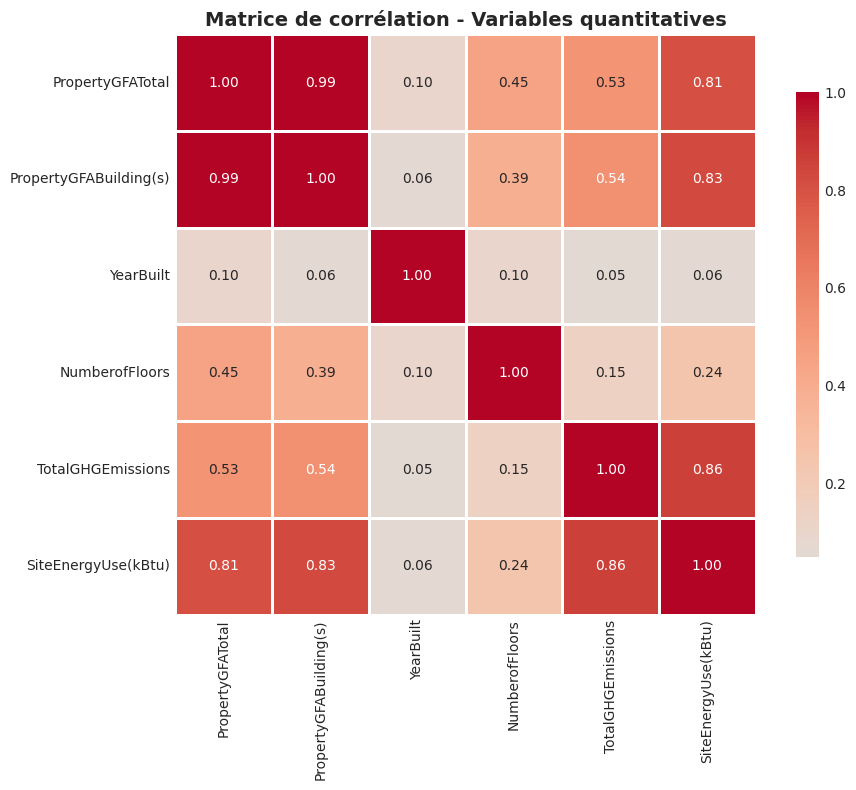

In [86]:
quanti_vars = [
    'PropertyGFATotal',
    'PropertyGFABuilding(s)',
    'YearBuilt',
    'NumberofFloors',
    TARGET_CO2,
    TARGET_ENERGY
]


df_quanti = df[quanti_vars]

# Calcul de la matrice de corrélation
correlation_matrix = df_quanti.corr()

# Visualisation : Heatmap de corrélation
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation - Variables quantitatives', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### 12.1.2 Surface totale vs ( Consommation d'énergie et Emission de CO2 )

Afin d’analyser l’impact de la surface totale des bâtiments sur leurs performances énergétiques et environnementales, nous comparons la surface totale à la consommation d’énergie ainsi qu’aux émissions de CO₂ à l’aide de nuages de points. Ces graphiques permettent d’observer la relation entre la taille des bâtiments et ces deux indicateurs, d’identifier d’éventuelles corrélations et de repérer des bâtiments atypiques

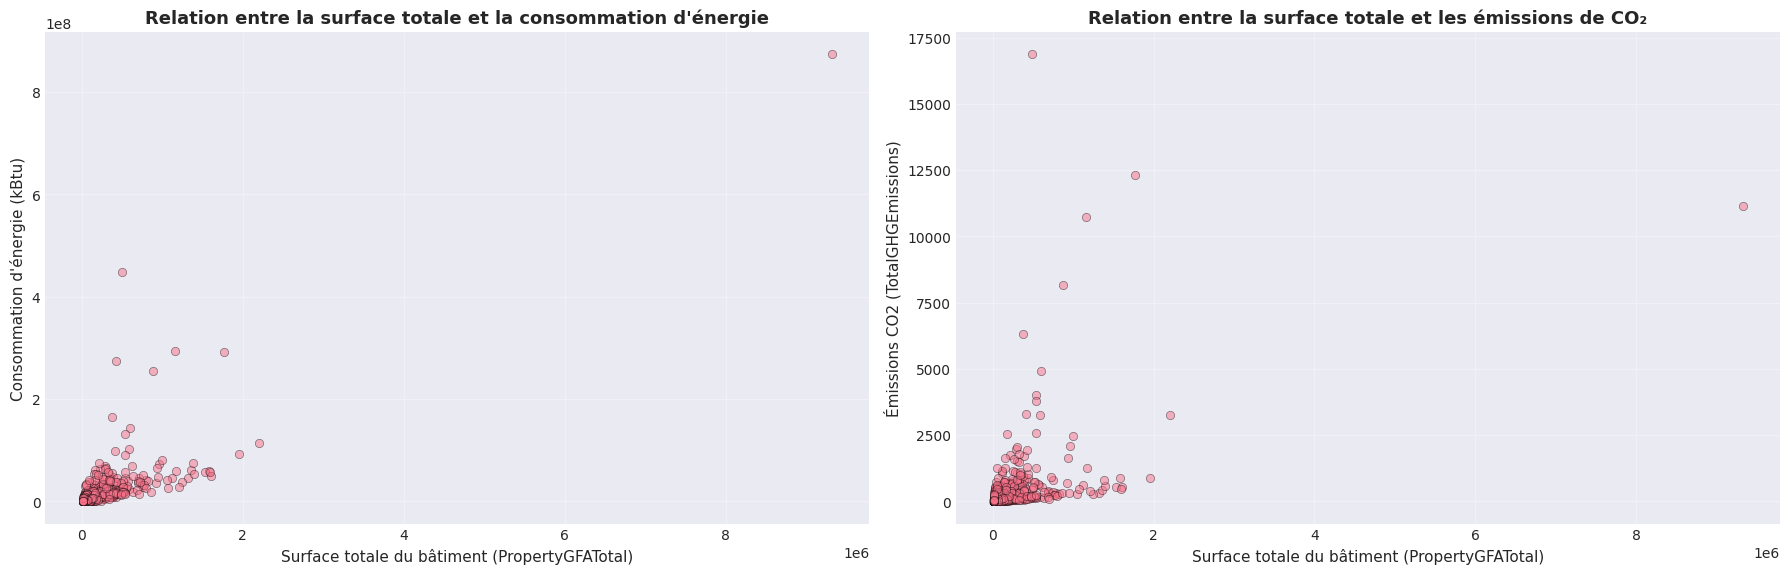

In [87]:
def create_scatter(
    df: pd.DataFrame,
    var1: str,
    var2: str,
    title: str,
    xlabel: str,
    ylabel: str,
    ax: plt.Axes,
    add_trendline: bool = False
):
    if add_trendline:
        sns.regplot(
            data=df,
            x=var1,
            y=var2,
            ax=ax,
            scatter_kws={
                "alpha": 0.5,
                "edgecolor": "k"
            },
            line_kws={
                "color": "red",
                "linewidth": 2
            },
            ci=None
        )
    else:
        sns.scatterplot(
            data=df,
            x=var1,
            y=var2,
            ax=ax,
            alpha=0.5,
            edgecolor="k"
        )

    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

create_scatter(
    df,
    "PropertyGFATotal",
    TARGET_ENERGY,
    "Relation entre la surface totale et la consommation d'énergie",
    "Surface totale du bâtiment (PropertyGFATotal)",
    "Consommation d'énergie (kBtu)",
    axes[0]
)

create_scatter(
    df,
    "PropertyGFATotal",
    TARGET_CO2,
    "Relation entre la surface totale et les émissions de CO₂",
    "Surface totale du bâtiment (PropertyGFATotal)",
    "Émissions CO2 (TotalGHGEmissions)",
    axes[1]
)

plt.tight_layout()
plt.show()



##### Analyse synthétique des relations surface – énergie et CO₂

Les deux graphiques montrent une **relation positive globale** entre la surface totale des bâtiments et :
- la **consommation d’énergie** ;
- les **émissions de CO₂**.

En général, plus un bâtiment est grand, plus il consomme d’énergie et plus il émet de CO₂.  
Cependant, pour une **même surface**, on observe une **forte variabilité** des consommations et des émissions, ce qui indique que la surface seule n’explique pas tout.

Cette dispersion s’explique notamment par :
- le **type et l’usage** des bâtiments ;
- leur **performance énergétique** ;
- le **type d’énergie utilisée**, qui influence directement les émissions de CO₂.

Quelques bâtiments de très grande surface présentent des valeurs extrêmes, ce qui souligne l’intérêt de :
- normaliser les indicateurs (énergie/m², CO₂/m²) ;
- analyser séparément certains bâtiments atypiques.

**Conclusion :**  
La surface est un facteur explicatif important, mais insuffisant à elle seule. Une analyse plus fine nécessite des indicateurs normalisés et une segmentation par usage ou type de bâtiment.


#### 12.1.3 Année de construction vs Consommation d'énergie

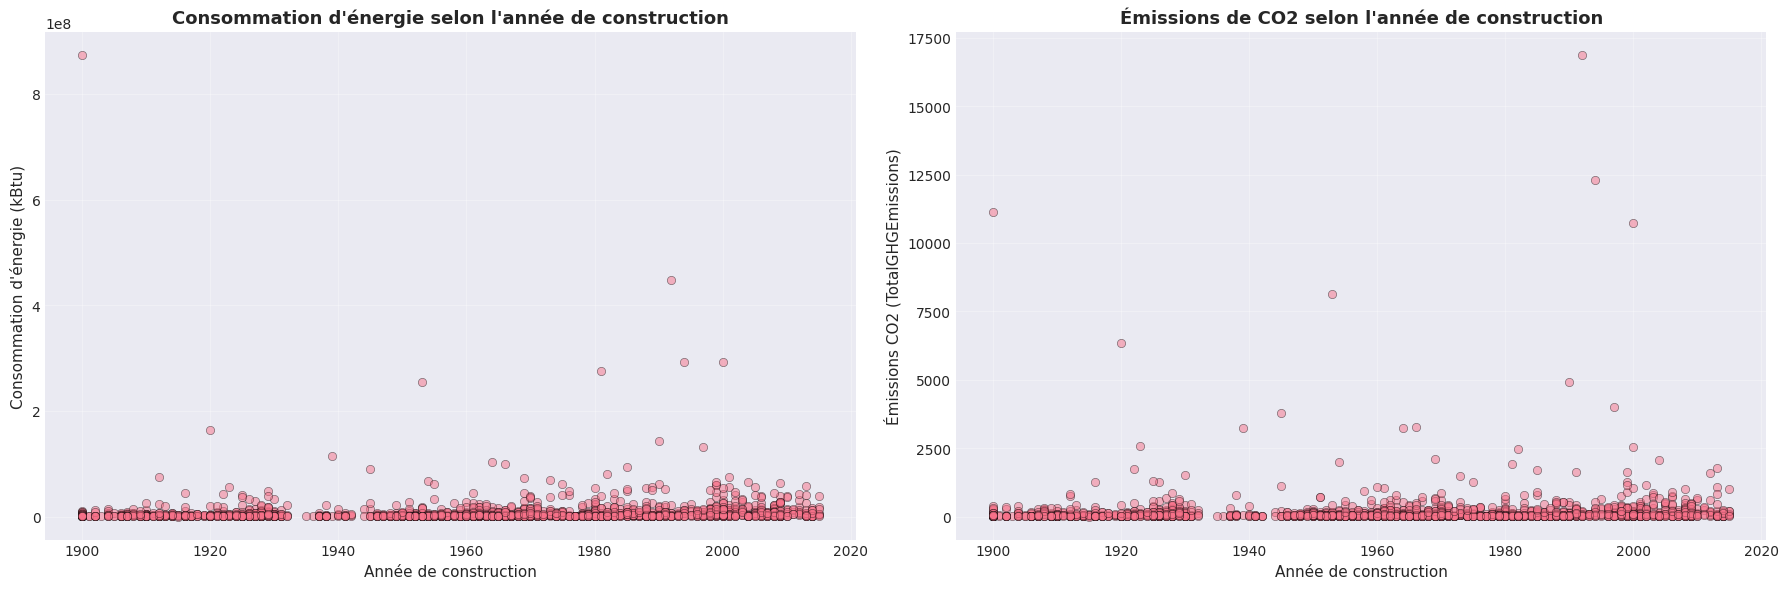

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

create_scatter(
    df,
    "YearBuilt",
    TARGET_ENERGY,
    "Consommation d'énergie selon l'année de construction",
    "Année de construction",
    "Consommation d'énergie (kBtu)",
    axes[0]
)

create_scatter(
    df,
    "YearBuilt",
    TARGET_CO2,
    "Émissions de CO2 selon l'année de construction",
    "Année de construction",
    "Émissions CO2 (TotalGHGEmissions)",
    axes[1]
)

plt.tight_layout()
plt.show()

### Analyse synthétique – année de construction, énergie et CO₂

Aucune tendance linéaire forte n’apparaît clairement entre l’année de construction et les niveaux de consommation ou d’émissions. Des bâtiments anciens comme récents peuvent présenter des consommations et des émissions élevées.

On observe toutefois que :
- la majorité des bâtiments, quelle que soit leur année de construction, a des **consommations et émissions relativement faibles** ;
- quelques **valeurs extrêmes** sont présentes sur l’ensemble de la période, ce qui suggère que l’année de construction seule n’est pas un facteur explicatif suffisant.

Ces résultats indiquent que :
- l’**usage du bâtiment**, sa **taille**, et ses **rénovations énergétiques** ont probablement un impact plus important que l’année de construction initiale ;
- les bâtiments récents ne sont pas systématiquement les plus performants, et certains bâtiments anciens peuvent être efficaces s’ils ont été rénovés.

**Conclusion :**  
L’année de construction, prise isolément, explique peu la consommation d’énergie et les émissions de CO₂. Une analyse plus pertinente nécessiterait d’intégrer des informations sur les rénovations, les usages et des indicateurs normalisés (énergie/m², CO₂/m²).


### 12.2. Quantitative vs Qualitative

**Objectif :** Comparer une variable numérique selon différentes catégories.

**Mesure :** ANOVA, Rapport de corrélation η² (entre 0 et 1)

**Graphiques :**
- Boxplot
- Violin plot
- Bar plot (moyennes)

**Exemples :**
- Consommation d'énergie et Émissions CO2 selon le type de propriété
- Consommation d'énergie et Émissions CO2 selon le quartier
- Consommation d'énergie et Émissions CO2 selon le type de bâtiment

#### 12.2.1 Consommation d'énergie selon le type de propriété

In [89]:
def create_boxplot(
    df: pd.DataFrame,
    y_col: str,
    ax: plt.Axes,
    x_col: str = None,
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    rotate_x: int = 0,
    log_scale: bool = False
):
    sns.boxplot(
        data=df,
        x=x_col,
        y=y_col,
        ax=ax
    )

    if log_scale:
        ax.set_yscale("log")
        title = title + "(log scale)"
        ylabel = ylabel + "(log scale)"

    if rotate_x:
        ax.tick_params(axis='x', rotation=rotate_x)


    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)


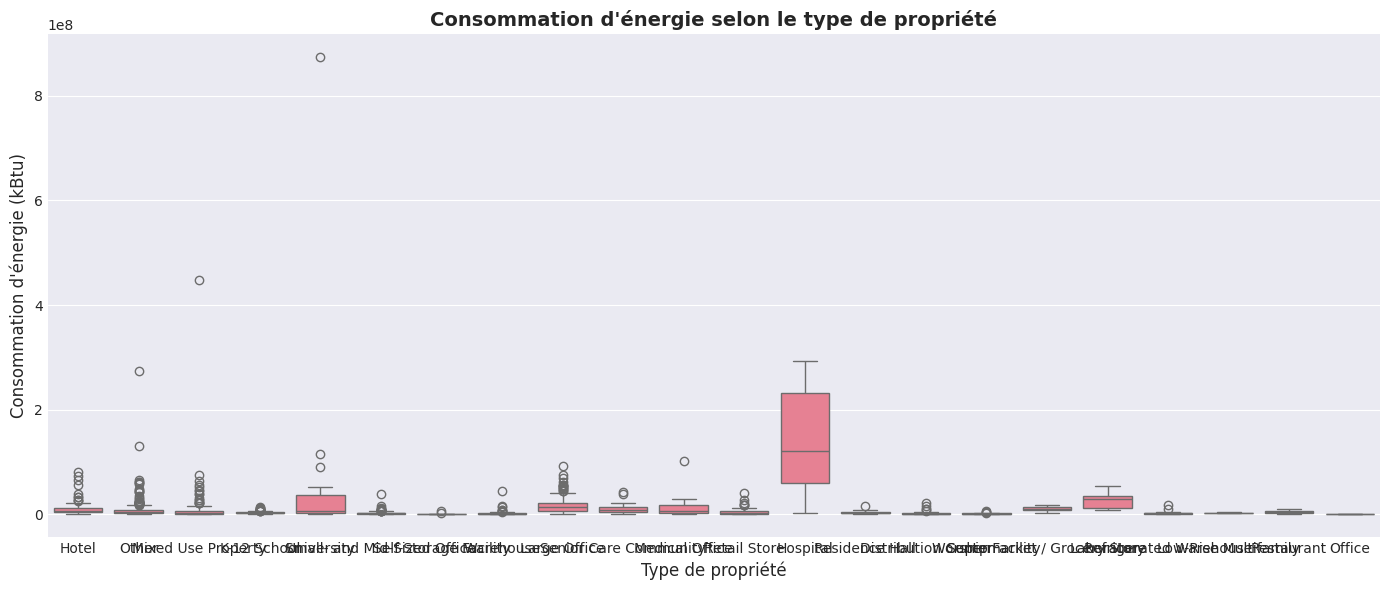

In [90]:
fig, ax = plt.subplots(figsize=(14, 6))
create_boxplot(
	df,
	TARGET_ENERGY,
	ax,
	'PrimaryPropertyType', 
	'Consommation d\'énergie selon le type de propriété',
	'Type de propriété', 
	'Consommation d\'énergie (kBtu)'
	)
plt.tight_layout()
plt.show()

##### Analyse synthétique – consommation d’énergie selon le type de propriété

On observe des **différences marquées entre les catégories** :
- Les **hôpitaux** présentent de loin les consommations d’énergie les plus élevées, avec une médiane importante et une forte dispersion. Cela s’explique par une activité continue, des équipements lourds et des exigences sanitaires élevées.
- Les **universités**, les **laboratoires**, les **supermarchés** et les **grands bureaux** affichent également des niveaux de consommation plus élevés que la moyenne.
- Les **écoles K-12**, les **bureaux**, les **restaurants**, les **entrepôts** et les **logements collectifs de faible hauteur** présentent des consommations globalement plus faibles.

La présence de nombreux **outliers** dans plusieurs catégories indique une **forte hétérogénéité interne**, liée notamment à la taille des bâtiments, à leur usage réel et à leur intensité d’exploitation.

**Conclusion :**  
Le type de propriété est un facteur déterminant de la consommation d’énergie. Toutefois, les écarts observés au sein d’une même catégorie montrent que des indicateurs normalisés (énergie/m²) et une segmentation plus fine restent nécessaires pour comparer efficacement la performance énergétique des bâtiments.


#### 12.2.2 Émissions CO2 selon le type de propriété

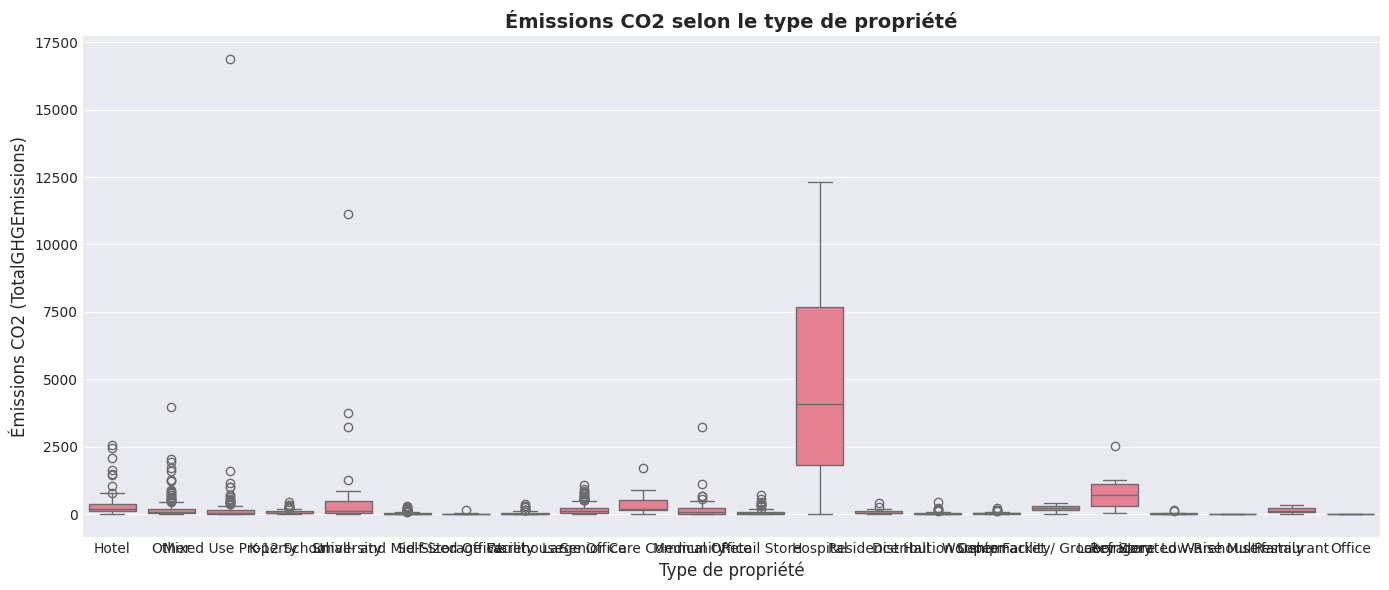

In [91]:
# Visualisation : Boxplot
fig, ax = plt.subplots(figsize=(14, 6))
create_boxplot(df, TARGET_CO2, ax, 'PrimaryPropertyType', 'Émissions CO2 selon le type de propriété', 'Type de propriété', 'Émissions CO2 (TotalGHGEmissions)')
plt.tight_layout()
plt.show()

##### Analyse synthétique – émissions de CO₂ selon le type de propriété

Des écarts importants apparaissent entre les catégories :
- Les **hôpitaux** sont de loin les plus émetteurs, avec des valeurs médianes élevées et une dispersion très marquée. Cela reflète une consommation énergétique continue et souvent basée sur des sources fortement carbonées.
- Les **universités**, les **laboratoires**, les **supermarchés / épiceries** et les **grands bureaux** présentent également des niveaux d’émissions plus élevés que la moyenne.
- Les **bureaux standards**, **écoles K-12**, **entrepôts**, **restaurants** et **bâtiments résidentiels de faible hauteur** affichent des émissions globalement plus faibles.

La présence de nombreux **outliers** dans plusieurs catégories souligne une **forte hétérogénéité** au sein d’un même type de propriété, liée à la taille, à l’intensité d’usage et au mix énergétique.

**Conclusion :**  
Le type de propriété est un facteur clé des émissions de CO₂, mais il ne suffit pas à lui seul pour comparer la performance environnementale. L’utilisation d’indicateurs normalisés (CO₂/m² ou CO₂ par usage) et une analyse par type d’énergie permettraient une interprétation plus robuste.


#### 12.2.3 Consommation d’énergie et émissions de CO₂ selon le quartier

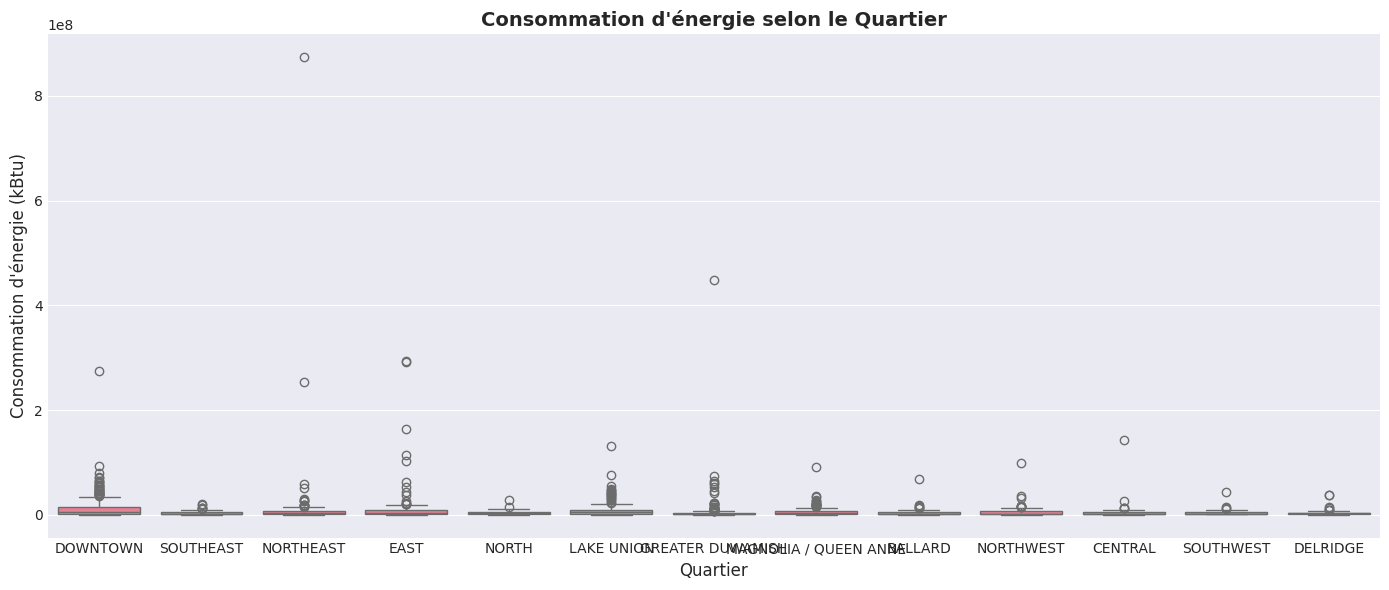

In [92]:
fig, ax = plt.subplots(figsize=(14, 6))
create_boxplot(df, TARGET_ENERGY,ax , 'Neighborhood', 'Consommation d\'énergie selon le Quartier','Quartier', 'Consommation d\'énergie (kBtu)')
plt.tight_layout()
plt.show()

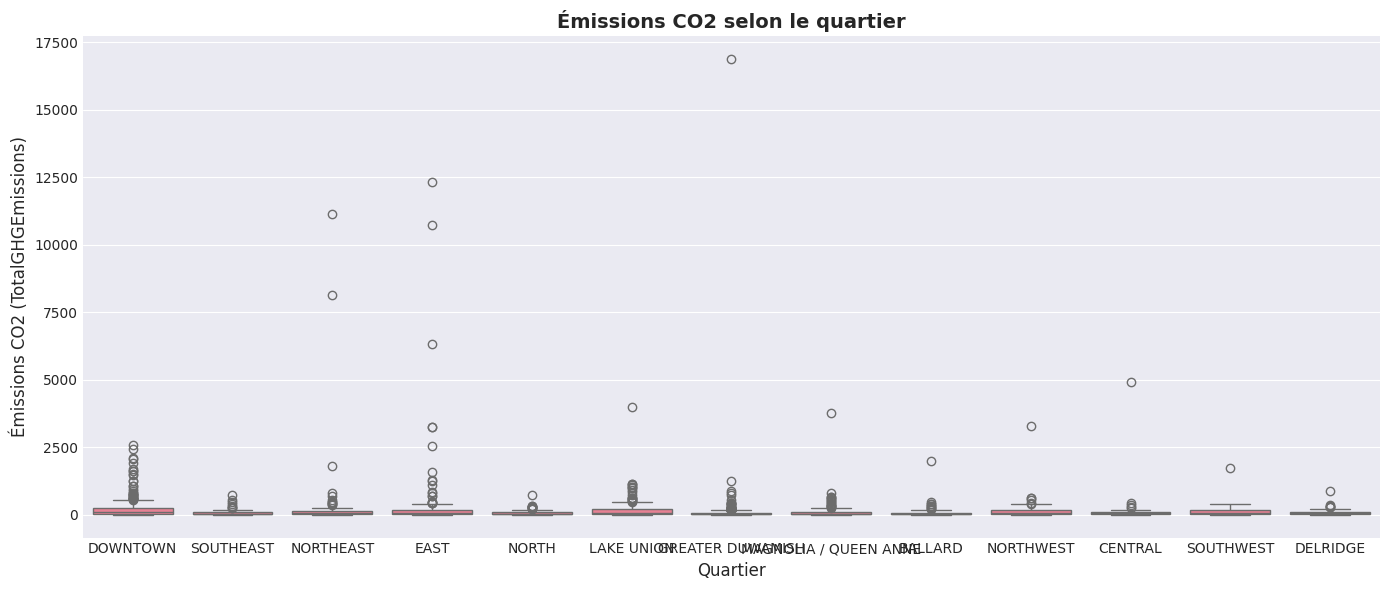

In [93]:
fig, ax = plt.subplots(figsize=(14, 6))
create_boxplot(df, TARGET_CO2, ax,  'Neighborhood', 'Émissions CO2 selon le quartier','Quartier', 'Émissions CO2 (TotalGHGEmissions)')
plt.tight_layout()
plt.show()

##### Analyse synthétique – consommation d’énergie et émissions de CO₂ selon le quartier

Globalement, on n’observe pas de différences extrêmement marquées entre les quartiers en termes de valeurs médianes : la majorité des bâtiments, quel que soit le quartier, présente des **consommations et émissions relativement faibles**.

Cependant, certains quartiers se distinguent par la présence de **valeurs extrêmes (outliers)** :
- **Downtown**, **East**, **Northeast** et **Greater Duwamish** concentrent plusieurs bâtiments avec des consommations d’énergie et des émissions de CO₂ très élevées.
- Ces quartiers sont probablement caractérisés par une plus forte densité de bâtiments de grande taille ou à usage intensif (hôpitaux, universités, bâtiments industriels ou tertiaires).

Les quartiers plus résidentiels ou moins denses (par exemple **North**, **Ballard**, **Magnolia / Queen Anne**, **Delridge**) présentent en général des niveaux plus faibles et moins dispersés.

**Conclusion :**  
Le quartier influence indirectement la consommation d’énergie et les émissions de CO₂, principalement via le **type de bâtiments** et leur **usage**. À lui seul, le quartier n’est pas un facteur explicatif suffisant. Une analyse combinant quartier, type de propriété et indicateurs normalisés (énergie/m², CO₂/m²) permettrait une interprétation plus robuste.


### 3. Qualitative vs Qualitative

**Objectif :** Analyser la dépendance entre deux variables catégorielles.

**Mesure :** Test du Chi², V de Cramér (entre 0 et 1)

**Graphiques :**
- Heatmap de contingence
- Stacked bar plot
- Tableau de contingence

**Exemples :**
- Type de bâtiment vs Quartier
- Type de bâtiment vs Type d'usage

In [94]:
def create_barplot_contingency(
    df: pd.DataFrame,
    x_col: str,
    hue_col: str,
    title: str,
    xlabel: str,
    ylabel: str,
    legend_title: str,
    top_n_x: int | None = None,
    top_n_y: int | None = None
):
    
    df_copy = df.copy()
    # Optionnel : limiter la cardinalité
    if top_n_x is not None:
        top_x = df_copy[x_col].value_counts().head(top_n_x).index
        df_copy = df_copy[df_copy[x_col].isin(top_x)]

    if top_n_y is not None:
        top_y = df_copy[hue_col].value_counts().head(top_n_y).index
        df_copy = df_copy[df_copy[hue_col].isin(top_y)]

    contingency = (
        df_copy
        .groupby([x_col, hue_col])
        .size()
        .reset_index(name='count')
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=contingency,
        x=x_col,
        y='count',
        hue=hue_col
    )

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=legend_title, )
    plt.tight_layout()
    plt.show()


def create_heatmap_contingency(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    title: str,
    xlabel: str,
    ylabel: str,
    top_n_x: int | None = None,
    top_n_y: int | None = None,
    normalize: bool = False,
    annot: bool = False,
    fmt: str = 'd'
):
    data = df.copy()

    if top_n_x is not None:
        top_x = data[x_col].value_counts().head(top_n_x).index
        data = data[data[x_col].isin(top_x)]

    if top_n_y is not None:
        top_y = data[y_col].value_counts().head(top_n_y).index
        data = data[data[y_col].isin(top_y)]

    contingency = pd.crosstab(
        data[y_col],
        data[x_col],
        normalize='index' if normalize else False
    )

    if annot and fmt is None:
        fmt = '.2f' if normalize else 'd'

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        contingency if not normalize else contingency * 100,
        cmap='Blues',
        annot=annot,
        fmt=fmt,
        linewidths=0.5
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1,12,88434,0,88434,Hotel,Hotel,88434.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1,41,956110,196718,759392,Hotel,Hotel,756493.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1,10,61320,0,61320,Hotel,Hotel,61320.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,505.01,2.88


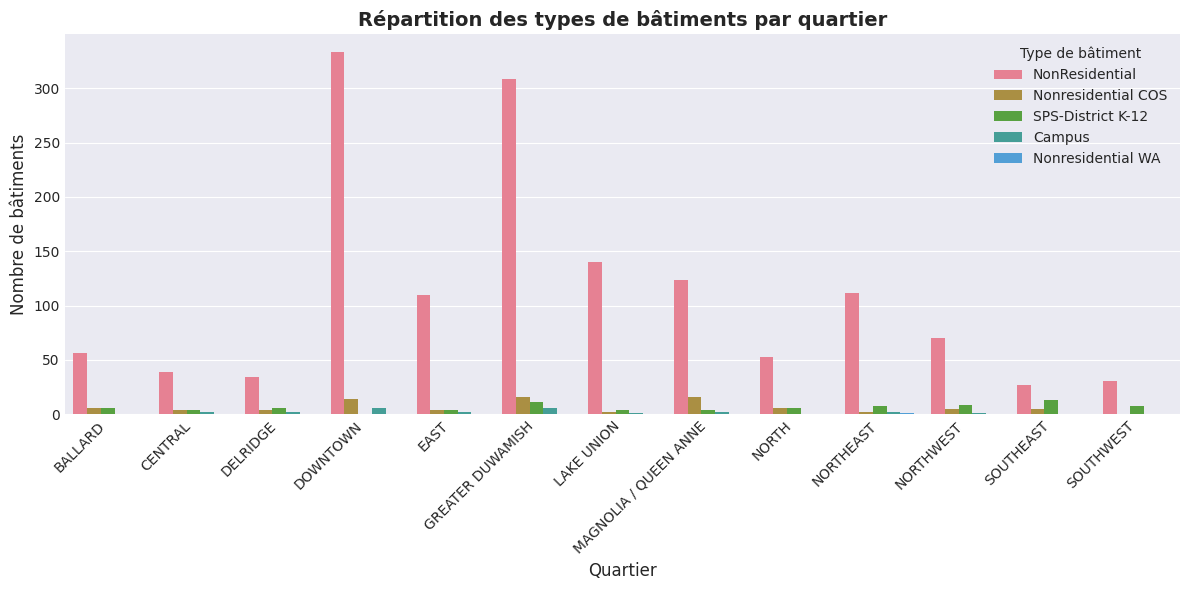

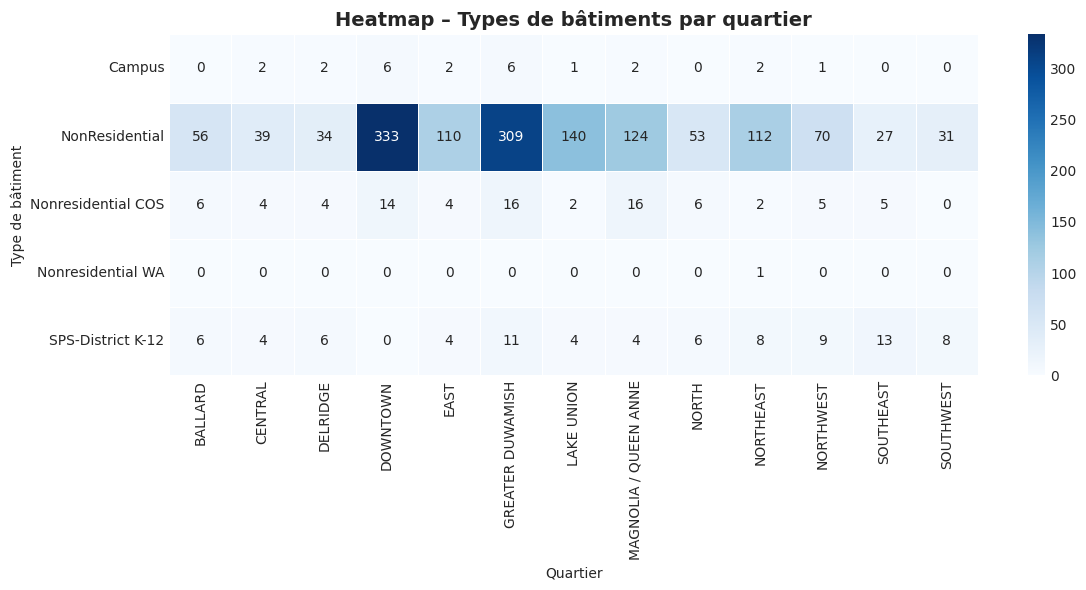

In [95]:
display(df.head())
create_barplot_contingency(
    df,
    'Neighborhood',
    'BuildingType',
    'Répartition des types de bâtiments par quartier',
    'Quartier',
    'Nombre de bâtiments',
    'Type de bâtiment'
)
create_heatmap_contingency(
    df,
    x_col='Neighborhood',
    y_col='BuildingType',
    title="Heatmap – Types de bâtiments par quartier",
    xlabel="Quartier",
    ylabel="Type de bâtiment",
    normalize=False,  # True si tu veux des proportions
    annot=True
)


#### Analyse synthétique – répartition des types de bâtiments par quartier

Les résultats mettent en évidence une **forte domination des bâtiments non résidentiels** dans l’ensemble des quartiers. Cette domination est particulièrement marquée dans :
- **Downtown** et **Greater Duwamish**, qui concentrent de loin le plus grand nombre de bâtiments non résidentiels ;
- **Lake Union**, **Magnolia / Queen Anne**, **East** et **Northeast**, qui présentent également des volumes significatifs.

Les autres catégories de bâtiments sont **largement minoritaires** :
- Les **Nonresidential COS** et **SPS-District K-12** sont présents dans presque tous les quartiers, mais en quantités limitées.
- Les **campus** sont très peu nombreux et localisés dans quelques quartiers spécifiques.
- Les **Nonresidential WA** sont quasi inexistants dans l’échantillon.

La heatmap confirme visuellement ces tendances en montrant une **forte concentration** de bâtiments non résidentiels dans certains quartiers, tandis que les autres types restent dispersés et peu représentés.

**Conclusion :**  
La structure du parc immobilier varie fortement selon les quartiers, avec une concentration des bâtiments non résidentiels dans les zones à forte activité économique (notamment Downtown et Greater Duwamish). Cette répartition explique en partie les différences observées précédemment en matière de consommation d’énergie et d’émissions de CO₂, soulignant l’importance de croiser **quartier**, **type de bâtiment** et **usage** pour une analyse énergétique pertinente.


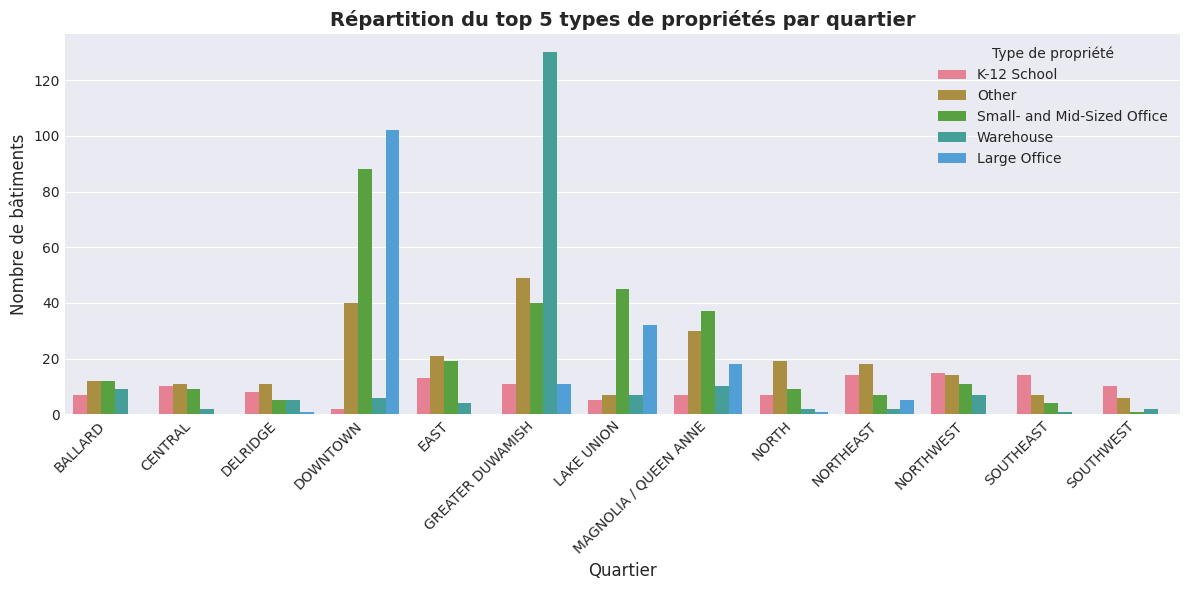

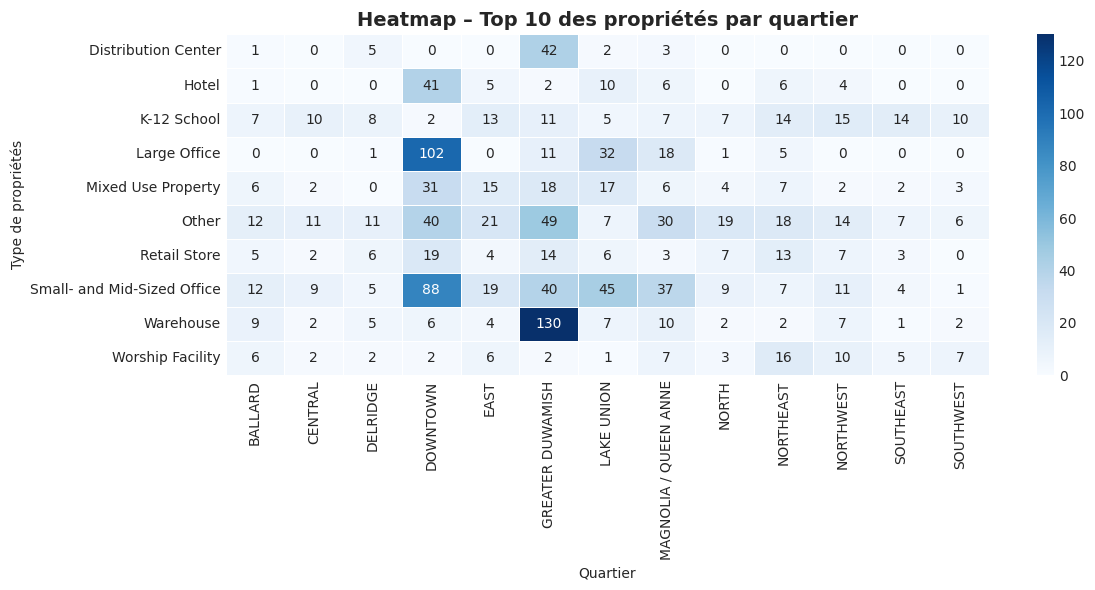

In [96]:
create_barplot_contingency(
    df,
    'Neighborhood',
    'PrimaryPropertyType',
    'Répartition du top 5 types de propriétés par quartier',
    'Quartier',
    'Nombre de bâtiments',
    'Type de propriété',
    top_n_y=5
)
create_heatmap_contingency(
    df,
    x_col='Neighborhood',
    y_col='PrimaryPropertyType',
    title="Heatmap – Top 10 des propriétés par quartier",
    xlabel="Quartier",
    ylabel="Type de propriétés",
    top_n_y=10,      # fortement recommandé
    normalize=False,  # True si tu veux des proportions
    annot=True
)

#### Analyse synthétique – répartition des types de propriétés par quartier (Top 5 et Top 10)

Ces deux visualisations présentent la **distribution des principaux types de propriétés selon les quartiers**, à travers :
- un graphique en barres pour le **Top 5 des types de propriétés** ;
- une heatmap pour le **Top 10 des types de propriétés**.

##### Tendances générales
- Certains quartiers concentrent très fortement des **types de propriétés spécifiques**, révélant une spécialisation fonctionnelle claire.
- **Downtown** se distingue par une forte concentration de **Large Offices**, **Small and Mid-Sized Offices**, ainsi que de **Mixed Use Properties**, ce qui confirme son rôle de pôle tertiaire majeur.
- **Greater Duwamish** est largement dominé par les **Warehouses** et les **Distribution Centers**, reflétant une vocation principalement industrielle et logistique.

##### Répartition par type de propriété
- Les **bureaux (Large et Small/Mid-Sized)** sont surtout présents à **Downtown**, **Lake Union** et **Magnolia / Queen Anne**.
- Les **entrepôts (Warehouses)** sont massivement concentrés à **Greater Duwamish**, avec une présence marginale dans les autres quartiers.
- Les **K-12 Schools** sont réparties de manière relativement homogène entre les quartiers, indiquant une implantation plus résidentielle et territoriale.
- Les catégories **Retail Store**, **Hotel** et **Worship Facility** apparaissent de façon plus diffuse, sans concentration extrême, mais avec des pics locaux selon les quartiers.

##### Lecture croisée des deux graphiques
- Le graphique Top 5 met en évidence les **dominances locales**, tandis que la heatmap Top 10 permet d’identifier les **types secondaires mais structurants** dans chaque quartier.
- Ensemble, ils montrent que la **composition du parc immobilier varie fortement d’un quartier à l’autre**, bien plus que le simple nombre total de bâtiments.

##### Conclusion
La répartition des types de propriétés par quartier révèle une **forte spécialisation spatiale** (tertiaire, industrielle, mixte ou résidentielle). Cette structure explique en grande partie les différences observées précédemment en matière de **consommation d’énergie** et d’**émissions de CO₂**, et souligne l’importance d’intégrer le **type de propriété** dans toute analyse énergétique ou environnementale à l’échelle urbaine.


## 13. Récapitulatif de l'analyse exploratoire 
   
##### Dataset initial
- Lignes : 3376  
- Colonnes : 46
- Pourcentage de cellule vide : 12.85%
   
##### Dataset après nettoyage exploratoire
- Lignes : 1630 (après filtrage type de bâtiment + outliers + compliance)  
- Colonnes : 39 
- Pourcentage de cellule vide : 0 % 
   
##### Décisions prises
1. Variables cibles : `TotalGHGEmissions` et `SiteEnergyUse(kBtu)`  
2. Colonnes supprimées : `Outlier`, `Comments`, `YearsENERGYSTARCertified`, `SecondLargestPropertyUseType`, `SecondLargestPropertyUseTypeGFA` ,`ThirdLargestPropertyUseType`,`ThirdLargestPropertyUseTypeGFA`, `ENERGYSTARScore`
3. Lignes supprimées : outliers, bâtiments non conformes, données manquantes  
4. Type de bâtiments conservés : bâtiments non résidentiels uniquement  
   
##### Insights clés pour la modélisation

- La **surface totale du bâtiment** est fortement corrélée aux deux variables cibles, mais ne suffit pas à expliquer seule la variabilité observée  
  → nécessité d’intégrer des variables complémentaires et/ou des indicateurs normalisés (énergie/m², CO₂/m²).

- Le **type de propriété** est l’un des facteurs les plus discriminants pour l’énergie et le CO₂  
  → variable catégorielle clé à encoder soigneusement (one-hot ou target encoding selon le modèle).

- L’**année de construction** présente un pouvoir explicatif limité prise isolément  
  → variable à conserver, mais avec un poids attendu modéré dans les modèles.

- Une **forte hétérogénéité intra-catégorie** (notamment pour les hôpitaux, universités et grands bureaux) est observée  
  → intérêt potentiel de modèles non linéaires capables de capturer des interactions complexes.

- La **localisation (quartier)** influence indirectement les cibles via la structure du parc immobilier  
  → variable utile en interaction avec le type de propriété plutôt qu’en effet direct.

- La présence de **valeurs extrêmes** justifie :
  - le filtrage des outliers en amont ;
  - l’utilisation de métriques robustes et/ou de transformations (log, scaling).

- La variabilité importante des consommations et émissions suggère que des **modèles multivariés** seront plus adaptés que des approches univariées ou purement linéaires.

Ces éléments orientent vers une approche de modélisation intégrant à la fois des **variables structurelles**, **fonctionnelles** et **spatiales**, avec une attention particulière portée à la normalisation et aux interactions entre variables.


In [97]:
df.to_csv('data/data_EDA.csv', index=False)